## FC for Widespread Pain Subjects
#### Input: *stc.mat
####  Output: con, visualization

In [17]:
import os
from pathlib import Path
import sys
sys.path.append("/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/")
from eeg_toolkit import preprocess, utils
import eeg_toolkit.functional_connectivity as fc

In [18]:
# Settings
times_tup, time_win_path = preprocess.get_time_window(5)

# data paths
data_dir = Path("../../Data")
processed_data_path = data_dir / "Processed Data"
stc_path = data_dir / "Source Time Courses"
EO_resting_data_path = stc_path / "Eyes Open"
EC_resting_data_path = stc_path / "Eyes Closed"
zscored_epochs_data_path = stc_path / "zscored_Epochs" / time_win_path

# save paths
subset = "Widespread_Pain"
fc_path = data_dir / "Functional Connectivity"
fc_subset_path = fc_path / subset
save_path = fc_subset_path

os.makedirs(save_path, exist_ok=True)

[-2.5,0.0,2.5]


In [19]:
# viable subjects
sub_ids = utils.import_subs(data_dir, "sub_ids.txt")
sub_ids = sub_ids[7:]  # select only 64ch subs and turn into set
sub_ids_CP = [el for el in sub_ids if el.startswith('0')]
sub_ids_HC = [el for el in sub_ids if el.startswith('C')]

# CP Subs with widespread pain
widespread_pain_CP = [
    '055',
    '052',
    '046',
    '039',
    '036',
    '031',
    '022',
    '045',
    '040',
    '034',
    '032',
    '024',
    '018'
]
# Sort and limit CP subs to only those with widespread pain
widespread_pain_CP.sort()
sub_ids_CP = widespread_pain_CP

# Exclude HEALTHY subjects with widespread pain
widespread_pain_HC = ['C1.','C23']
sub_ids_HC = [sub for sub in sub_ids_HC if sub not in widespread_pain_HC]

# Combine selected CP and HC subjects
sub_ids = sub_ids_CP + sub_ids_HC

# Exclude subjects with NaN source localization
NAN_SUBS = ['018','021','C1.','C2.','C3.']
sub_ids = [sub for sub in sub_ids if sub not in NAN_SUBS]

exclude_resting=True

# These subjects have no keypresses and thus no resting timestamps, but they do have epoched data
# TODO: estimate eyes open timestamps from alpha band power
NO_KEYPRESS = ['045', 'C1.', 'C5.', 'C8.', 'C20', 'C21', 'C22']
sub_ids = [sub for sub in sub_ids if sub not in NO_KEYPRESS]

print(sub_ids)

['022', '024', '031', '032', '034', '036', '039', '040', '046', '052', '055', 'C6.', 'C7.', 'C9.', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C24', 'C25', 'C26', 'C27']


In [21]:
# Chronic Pain Subs without widespread pain
sub_ids = utils.import_subs(data_dir, "sub_ids.txt")
sub_ids = sub_ids[7:]  # select only 64ch subs and turn into set
sub_ids_CP_wo_WSP = [el for el in sub_ids if el.startswith('0')]

sub_ids_CP_wo_WSP = [sub for sub in sub_ids if sub not in widespread_pain_HC]


NAN_SUBS = ['018','021','C1.','C2.','C3.']
sub_ids_CP_wo_WSP = [sub for sub in sub_ids_CP_wo_WSP if sub not in NAN_SUBS]

NO_KEYPRESS = ['045', 'C1.', 'C5.', 'C8.', 'C20', 'C21', 'C22']
sub_ids_CP_wo_WSP = [sub for sub in sub_ids_CP_wo_WSP if sub not in NO_KEYPRESS]

print(f"Chronics with widespread pain: {len(sub_ids_CP_wo_WSP)}")
print([el for el in sub_ids if el.startswith('0')])
print(f"Chronics without widespread pain: {len(sub_ids_CP_wo_WSP)}")
print([sub for sub in sub_ids_CP_wo_WSP])


Chronics with widespread pain: 50
['018', '020', '021', '022', '023', '024', '027', '029', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043', '044', '045', '046', '048', '049', '050', '051', '052', '053', '054', '055', '056', '057', '058']
Chronics without widespread pain: 50
['020', '022', '023', '024', '027', '029', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043', '044', '046', '048', '049', '050', '051', '052', '053', '054', '055', '056', '057', '058', 'C6.', 'C7.', 'C9.', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C24', 'C25', 'C26', 'C27']


In [4]:
sub_ids_CP = [el for el in sub_ids if el.startswith('0')]
sub_ids_HC = [el for el in sub_ids if el.startswith('C')]

print(f"Chronics: {len(sub_ids_CP)}")
print(f"Controls: {len(sub_ids_HC)}")
print(f"Total: {len(sub_ids)}")

Chronics: 11
Controls: 17
Total: 28


In [5]:
# Get stc only from selected labels
roi_names = [  # Left
    "rostralanteriorcingulate-lh",  # Left Rostral ACC
    "caudalanteriorcingulate-lh",  # Left Caudal ACC
    "postcentral-lh",  # Left S1,
    "insula-lh",
    "superiorfrontal-lh",  # Left Insula, Left DL-PFC,
    "medialorbitofrontal-lh",  # Left Medial-OFC
    # Right
    "rostralanteriorcingulate-rh",  # Right Rostral ACC
    "caudalanteriorcingulate-rh",  # Right Caudal ACC
    "postcentral-rh",  # , Right S1
    "insula-rh",
    "superiorfrontal-rh",  # Right Insula, Right DL-PFC
    "medialorbitofrontal-rh",
]  # Right Medial-OFC

Freq_Bands = {
    # 'delta': [0, 4],
    "theta": [4.0, 8.0],
    "alpha": [8.0, 13.0],
    # "beta": [13.0, 30.0],
    "low-gamma": [30.0, 58.5],
    # "notch": [58.5, 61.5],
    "high-gamma": [61.5, 100.0],
}
band_names = [band for band in Freq_Bands]

sfreq = 400  # Hz
tmin, tmax = 0.0, 1.5  # exclude the baseline period for connectivity estimation

# TODO: replace con methods and conditions once testing complete
con_methods = [
  "wpli2_debiased",
#   "dpli",
#   "plv",
]

# Include intermediate stimulus?
include_LS = False

conditions = (
    [
        "Hand NS",
        "Hand LS",
        "Hand HS",
        "Back NS",
        "Back LS",
        "Back HS",
        "Eyes Open",
        "Eyes Closed",
    ]
    if include_LS
    else [
        "Hand NS",
        # 'Hand LS',
        "Hand HS",
        # "Back NS",
        # 'Back LS',
        # "Back HS",
        # "Eyes Open",
        # "Eyes Closed",
    ]
)

groups=['Chronic Pain', 'Healthy Control']

In [6]:
# Compute the average connectivity for each subject in the Chronic Pain
sub_con_CP = {}
for sub_id in sub_ids_CP:
    print(sub_id)
    sub_avg_cons = fc.compute_sub_avg_con(
        sub_id,
        "Chronic Pain",
        processed_data_path,
        zscored_epochs_data_path,
        EO_resting_data_path,
        EC_resting_data_path,
        con_methods,
        conditions,
        roi_names,
        Freq_Bands,
        tmin,
        tmax,
        sfreq,
        include_LS=include_LS,
    )
    sub_con_CP[sub_id] = sub_avg_cons


022
Reading stimulus labels and pain ratings for Subject 022...

*stim_labels length = 56*
*pain_ratings_raw length = 56*

+----------------+----------------+
| Subject        | 022            |
+----------------+----------------+
| Condition      | Hand NS        |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | theta          |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequencies: 5.0Hz..8.0Hz (4 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Debiased WPLI Square
    computing cross-spectral density for epoch 1
    computing cross-spectral densi

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:154: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+----------------+
| Subject        | 022            |
+----------------+----------------+
| Condition      | Hand NS        |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequencies: 61.8Hz..99.8Hz (39 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS win

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:154: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+----------------+
| Subject        | 022            |
+----------------+----------------+
| Condition      | Hand HS        |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequencies: 61.8Hz..99.8Hz (39 points)
    connectivity scores will be averaged for each band
    Usi

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:154: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+----------------+
| Subject        | 024            |
+----------------+----------------+
| Condition      | Hand NS        |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:154: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+----------------+
| Subject        | 024            |
+----------------+----------------+
| Condition      | Hand HS        |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    freq

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:154: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+----------------+
| Subject        | 031            |
+----------------+----------------+
| Condition      | Hand NS        |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:154: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+----------------+
| Subject        | 031            |
+----------------+----------------+
| Condition      | Hand HS        |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computi

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:154: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:154: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+----------------+
| Subject        | 032            |
+----------------+----------------+
| Condition      | Hand HS        |
+----------------+----------------+
| Num. of epochs | 7              |
+----------------+----------------+
| Band           | alpha          |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequencies: 9.0Hz..13.0Hz (5 points)
    connectivity

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:154: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+----------------+
| Subject        | 034            |
+----------------+----------------+
| Condition      | Hand NS        |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | low-gamma      |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequencies: 30.9Hz..57.9Hz (28 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Debiased WPLI Square
    computing cross-spectral

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:154: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Debiased WPLI Square
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+----------------+
| Subject        | 034            |
+----------------+----------------+
| Condition      | Hand HS        |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:154: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+----------------+
| Subject        | 036            |
+----------------+----------------+
| Condition      | Hand NS        |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:154: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+----------------+
| Subject        | 036            |
+----------------+----------------+
| Condition      | Hand HS        |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    freq

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:154: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+----------------+
| Subject        | 039            |
+----------------+----------------+
| Condition      | Hand NS        |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequencies: 61.8Hz..99.8Hz (39 points)
    connectiv

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:154: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+----------------+
| Subject        | 039            |
+----------------+----------------+
| Condition      | Hand HS        |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequencies: 61.8Hz..99.8Hz (39 points)
    connectiv

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:154: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Debiased WPLI Square
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+----------------+
| Subject        | 040            |
+----------------+----------------+
| Condition      | Hand NS        |
+----------------+----------------+
| Num. of epochs | 9              |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+--

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:154: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+----------------+
| Subject        | 040            |
+----------------+----------------+
| Condition      | Hand HS        |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    freq

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:154: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+----------------+
| Subject        | 046            |
+----------------+----------------+
| Condition      | Hand NS        |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequencies: 61.8Hz..99.8Hz (39 points)
    connectiv

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:154: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+----------------+
| Subject        | 046            |
+----------------+----------------+
| Condition      | Hand HS        |
+----------------+----------------+
| Num. of epochs | 9              |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computin

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:154: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+----------------+
| Subject        | 052            |
+----------------+----------------+
| Condition      | Hand NS        |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    freq

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:154: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+----------------+
| Subject        | 052            |
+----------------+----------------+
| Condition      | Hand HS        |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    freq

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:154: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+----------------+
| Subject        | 055            |
+----------------+----------------+
| Condition      | Hand NS        |
+----------------+----------------+
| Num. of epochs | 9              |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.0

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:154: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


In [7]:
# Repeat for the Healthy Control group
sub_con_HC = {}
for sub_id in sub_ids_HC:
    print(sub_id)
    sub_avg_cons = fc.compute_sub_avg_con(
        sub_id,
        "Healthy Control",
        processed_data_path,
        zscored_epochs_data_path,
        EO_resting_data_path,
        EC_resting_data_path,
        con_methods,
        conditions,
        roi_names,
        Freq_Bands,
        tmin,
        tmax,
        sfreq,
        include_LS=include_LS,
    )
    sub_con_HC[sub_id] = sub_avg_cons


C6.
Reading stimulus labels and pain ratings for Subject C6....

*stim_labels length = 52*
*pain_ratings_raw length = 52*

+----------------+----------------+
| Subject        | C6.            |
+----------------+----------------+
| Condition      | Hand NS        |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | theta          |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequencies: 5.0Hz..8.0Hz (4 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Debiased WPLI Square
    computing cross-spectral density for epoch 1


/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:154: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+----------------+
| Subject        | C6.            |
+----------------+----------------+
| Condition      | Hand NS        |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | alpha          |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only usin

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:154: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+----------------+
| Subject        | C6.            |
+----------------+----------------+
| Condition      | Hand HS        |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:154: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+----------------+
| Subject        | C7.            |
+----------------+----------------+
| Condition      | Hand NS        |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:154: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+----------------+
| Subject        | C7.            |
+----------------+----------------+
| Condition      | Hand HS        |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computi

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:154: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+----------------+
| Subject        | C9.            |
+----------------+----------------+
| Condition      | Hand NS        |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:154: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Debiased WPLI Square
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+----------------+
| Subject        | C9.            |
+----------------+----------------+
| Condition      | Hand HS        |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:154: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+----------------+
| Subject        | C10            |
+----------------+----------------+
| Condition      | Hand NS        |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequencies: 61.8Hz..99.8Hz (39 points)
    connectiv

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:154: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+----------------+
| Subject        | C10            |
+----------------+----------------+
| Condition      | Hand HS        |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | low-gamma      |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequencies: 30.9Hz..57.9Hz (28 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Debiased WPLI Square
    computing cross-spectral density for epoch 1
    computing cross-spectral 

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:154: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+----------------+
| Subject        | C11            |
+----------------+----------------+
| Condition      | Hand NS        |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    freq

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:154: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+----------------+
| Subject        | C11            |
+----------------+----------------+
| Condition      | Hand HS        |
+----------------+----------------+
| Num. of epochs | 9              |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequencies: 61.8Hz..99.8Hz (39 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS wind

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:154: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+----------------+
| Subject        | C12            |
+----------------+----------------+
| Condition      | Hand NS        |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computi

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:154: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+----------------+
| Subject        | C12            |
+----------------+----------------+
| Condition      | Hand HS        |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    freq

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:154: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+----------------+
| Subject        | C13            |
+----------------+----------------+
| Condition      | Hand NS        |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    freq

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:154: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+----------------+
| Subject        | C13            |
+----------------+----------------+
| Condition      | Hand HS        |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    freq

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:154: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+----------------+
| Subject        | C14            |
+----------------+----------------+
| Condition      | Hand NS        |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computi

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:154: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+----------------+
| Subject        | C14            |
+----------------+----------------+
| Condition      | Hand HS        |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:154: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+----------------+
| Subject        | C15            |
+----------------+----------------+
| Condition      | Hand NS        |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computi

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:154: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+----------------+
| Subject        | C15            |
+----------------+----------------+
| Condition      | Hand HS        |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+------

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:154: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+----------------+
| Subject        | C16            |
+----------------+----------------+
| Condition      | Hand NS        |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computi

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:154: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+----------------+
| Subject        | C16            |
+----------------+----------------+
| Condition      | Hand HS        |
+----------------+----------------+
| Num. of epochs | 9              |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequencies: 61.8Hz..99.8Hz (39 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS wind

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:154: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+----------------+
| Subject        | C17            |
+----------------+----------------+
| Condition      | Hand NS        |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only usin

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:154: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+----------------+
| Subject        | C17            |
+----------------+----------------+
| Condition      | Hand HS        |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    freq

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:154: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+----------------+
| Subject        | C18            |
+----------------+----------------+
| Condition      | Hand NS        |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | low-gamma      |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequencies: 30.9Hz..57.9Hz (28 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Debiased WPLI Square
    computing cross-spectral density for epoch 1
    computing cross-spectral 

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:154: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+----------------+
| Subject        | C18            |
+----------------+----------------+
| Condition      | Hand HS        |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    freq

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:154: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+----------------+
| Subject        | C19            |
+----------------+----------------+
| Condition      | Hand NS        |
+----------------+----------------+
| Num. of epochs | 9              |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.0

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:154: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+----------------+
| Subject        | C19            |
+----------------+----------------+
| Condition      | Hand HS        |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computi

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:154: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+----------------+
| Subject        | C24            |
+----------------+----------------+
| Condition      | Hand NS        |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | low-gamma      |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequencies: 30.9Hz..57.9Hz (28 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Debiased WPLI Square
    computing cross-spectral density for epoch 1
    computing cross-spectral 

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:154: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+----------------+
| Subject        | C24            |
+----------------+----------------+
| Condition      | Hand HS        |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequencies: 61.8Hz..99.8Hz (39 points)
    connectiv

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:154: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+----------------+
| Subject        | C25            |
+----------------+----------------+
| Condition      | Hand NS        |
+----------------+----------------+
| Num. of epochs | 9              |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequ

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:154: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+----------------+
| Subject        | C25            |
+----------------+----------------+
| Condition      | Hand HS        |
+----------------+----------------+
| Num. of epochs | 9              |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequencies: 61.8Hz..99.8Hz (39 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS wind

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:154: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computing cross-spectral density for epoch 20
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+----------------+
| Subject        | C26            |
+----------------+----------------+
| Condition      | Hand NS        |
+----------------+----------------+
| Num. of epochs | 20             |
+----------------+----------------+
| Band           | low-gamma      |
+----------------+----------------+
|

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:154: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Debiased WPLI Square
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral dens

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:154: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 8
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+----------------+
| Subject        | C27            |
+----------------+----------------+
| Condition      | Hand NS        |
+----------------+----------------+
| Num. of epochs | 8              |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequencies: 61.8Hz..99.8Hz (39 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Debiased WPLI Square
    computing cross-spectral 

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:154: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+----------------+
| Subject        | C27            |
+----------------+----------------+
| Condition      | Hand HS        |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    freq

In [8]:
# Stack the connectivity of all subjects in each group
group_con_CP = fc.compute_group_con(sub_con_CP, conditions, con_methods, band_names)
group_con_HC = fc.compute_group_con(sub_con_HC, conditions, con_methods, band_names)

In [9]:
# Save/checkpoint as pickle
utils.pickle_data(save_path, f"sub_con_{subset}_CP.pkl", sub_con_CP)
utils.pickle_data(save_path, f"sub_con_{subset}_HC.pkl", sub_con_HC)

utils.pickle_data(save_path, f"group_con_{subset}_CP.pkl", group_con_CP)
utils.pickle_data(save_path, f"group_con_{subset}_HC.pkl", group_con_HC)

Saved sub_con_Widespread_Pain_CP.pkl to ../../Data/Functional Connectivity/Widespread_Pain.
Saved sub_con_Widespread_Pain_HC.pkl to ../../Data/Functional Connectivity/Widespread_Pain.
Saved group_con_Widespread_Pain_CP.pkl to ../../Data/Functional Connectivity/Widespread_Pain.
Saved group_con_Widespread_Pain_HC.pkl to ../../Data/Functional Connectivity/Widespread_Pain.


### Assess statistical differences 

Chronic Pain - Hand NS vs. Hand HS - wpli2_debiased - theta
Number of epochs in Chronic Pain Hand NS = 102
Number of epochs in Chronic Pain Hand NS = 100


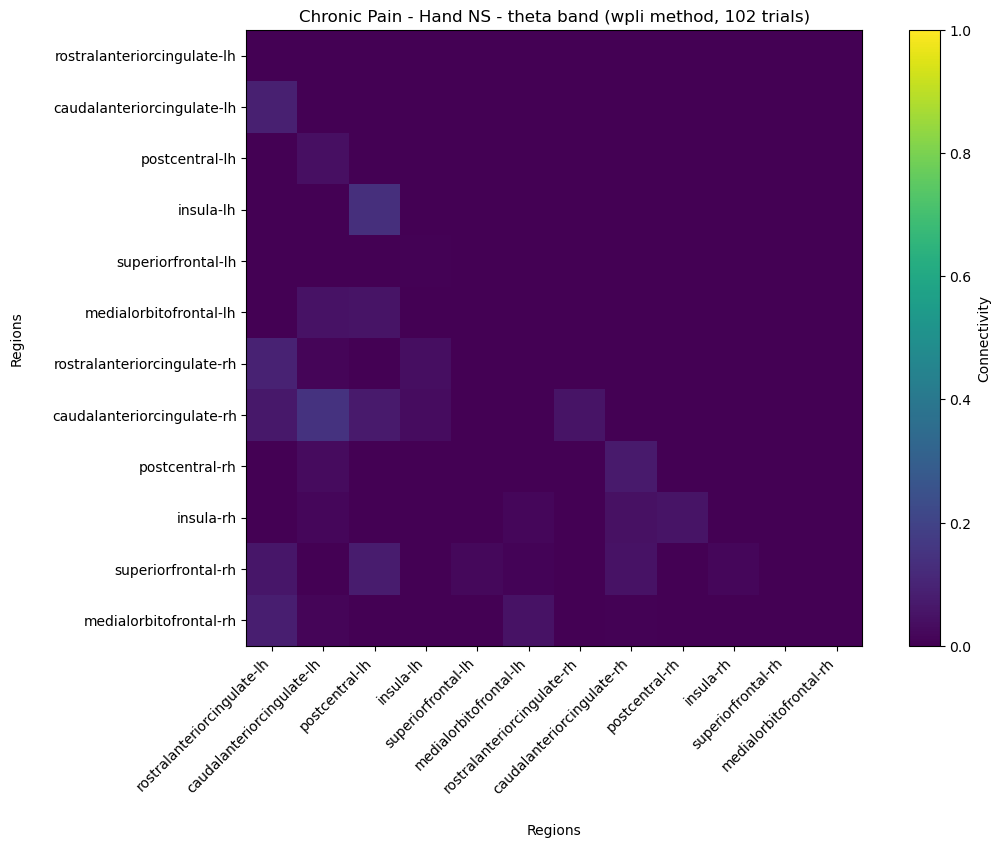

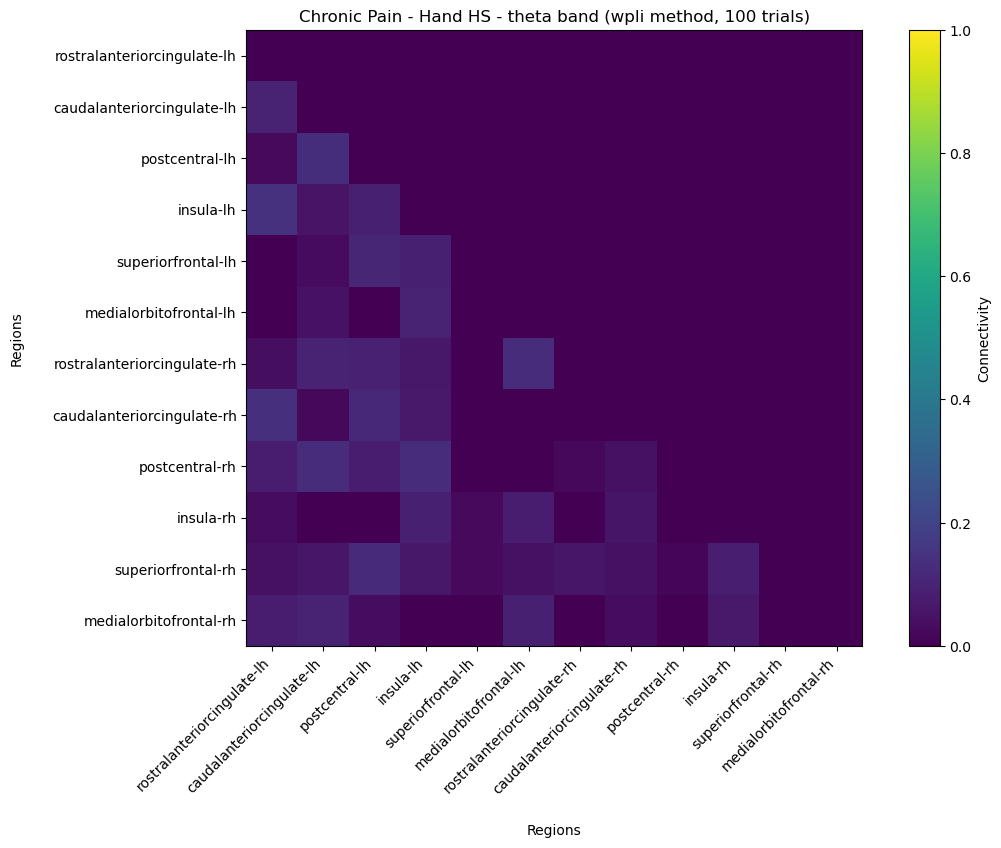

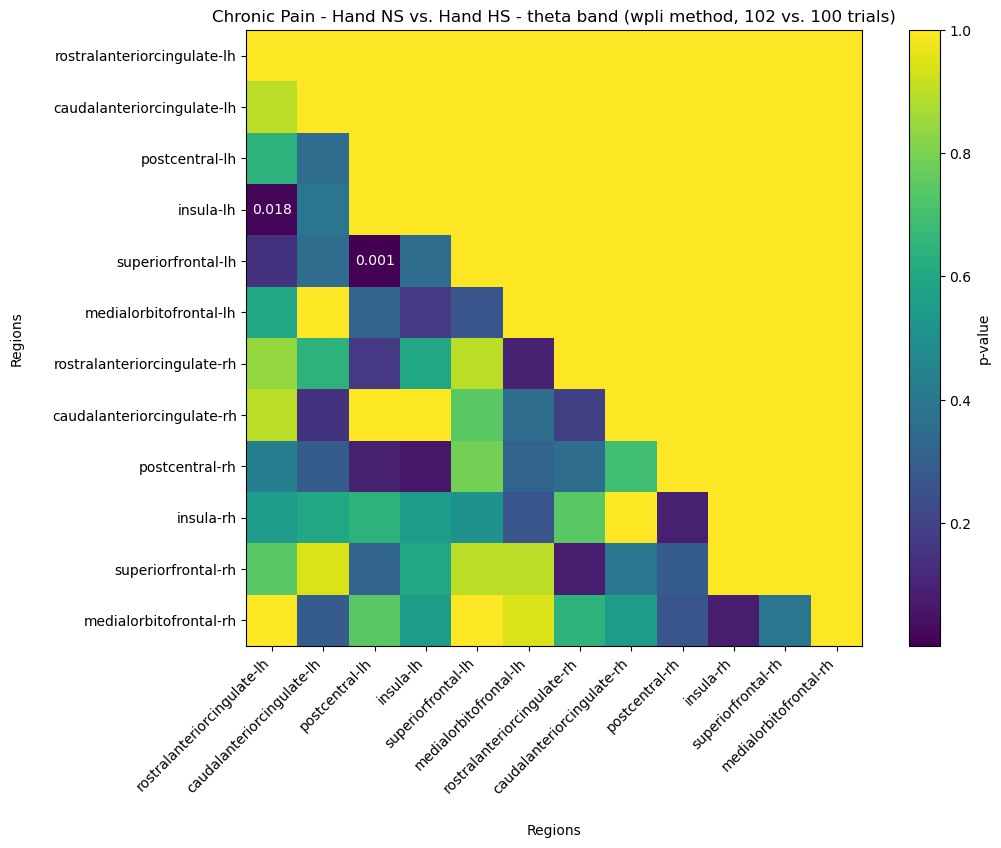

Chronic Pain - Hand NS vs. Hand HS - wpli2_debiased - alpha
Number of epochs in Chronic Pain Hand NS = 102
Number of epochs in Chronic Pain Hand NS = 100


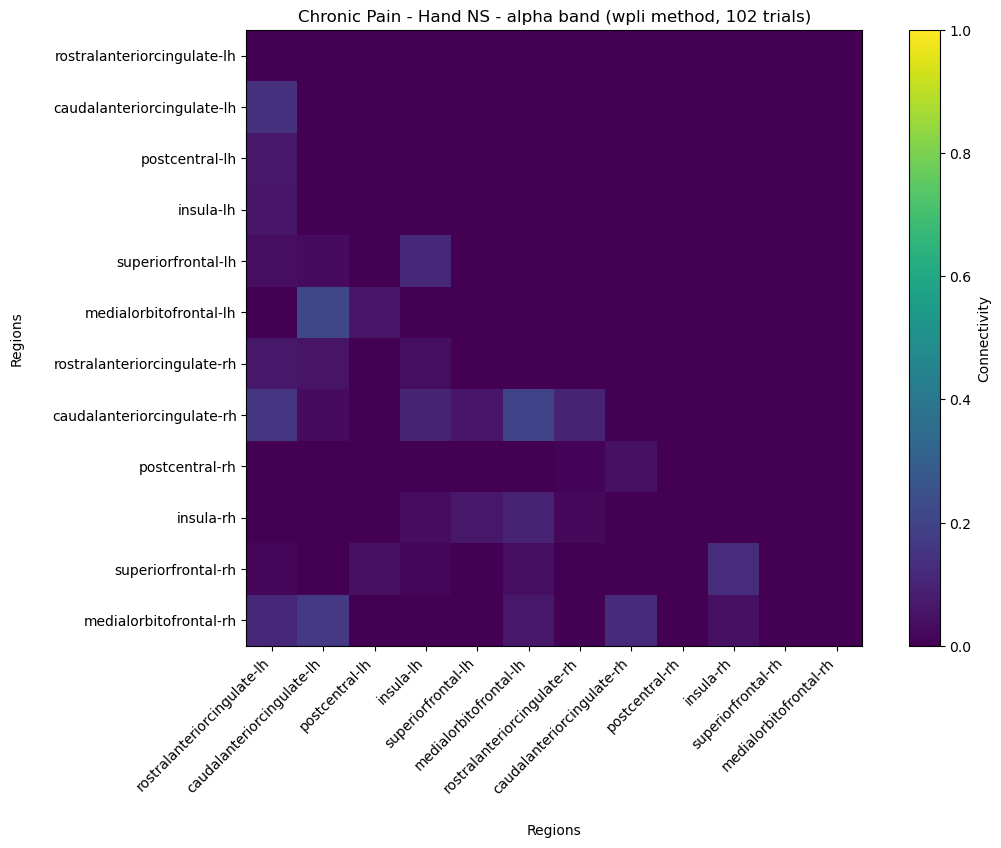

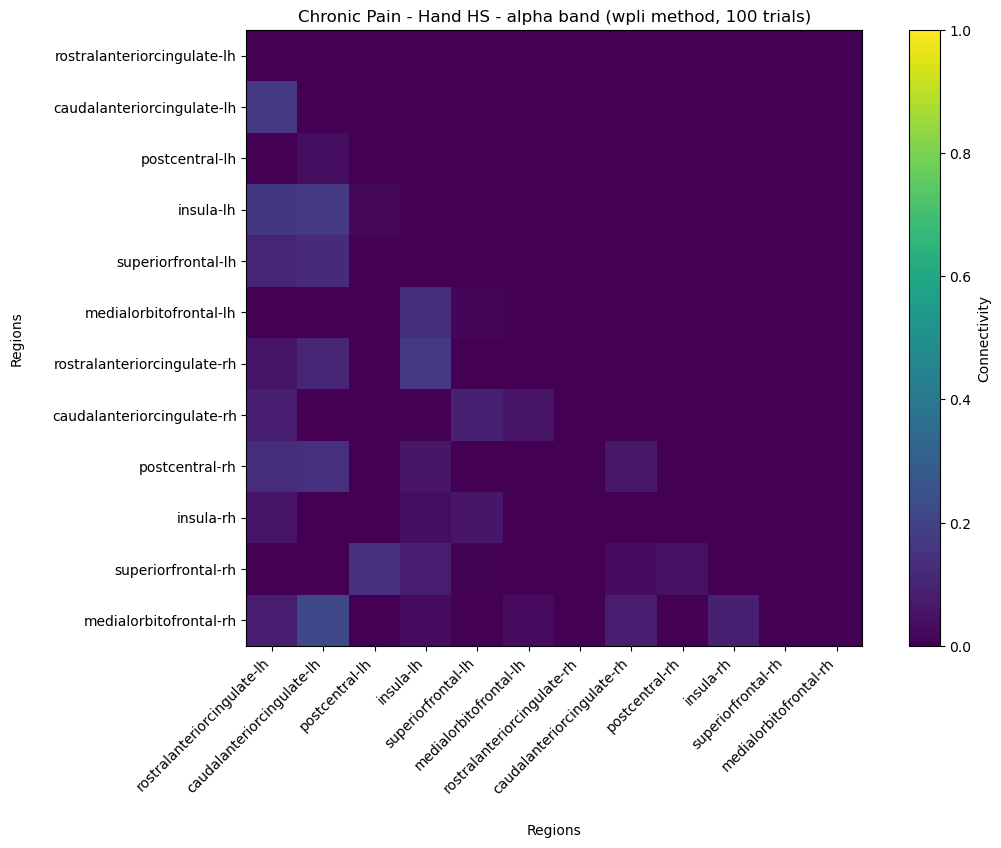

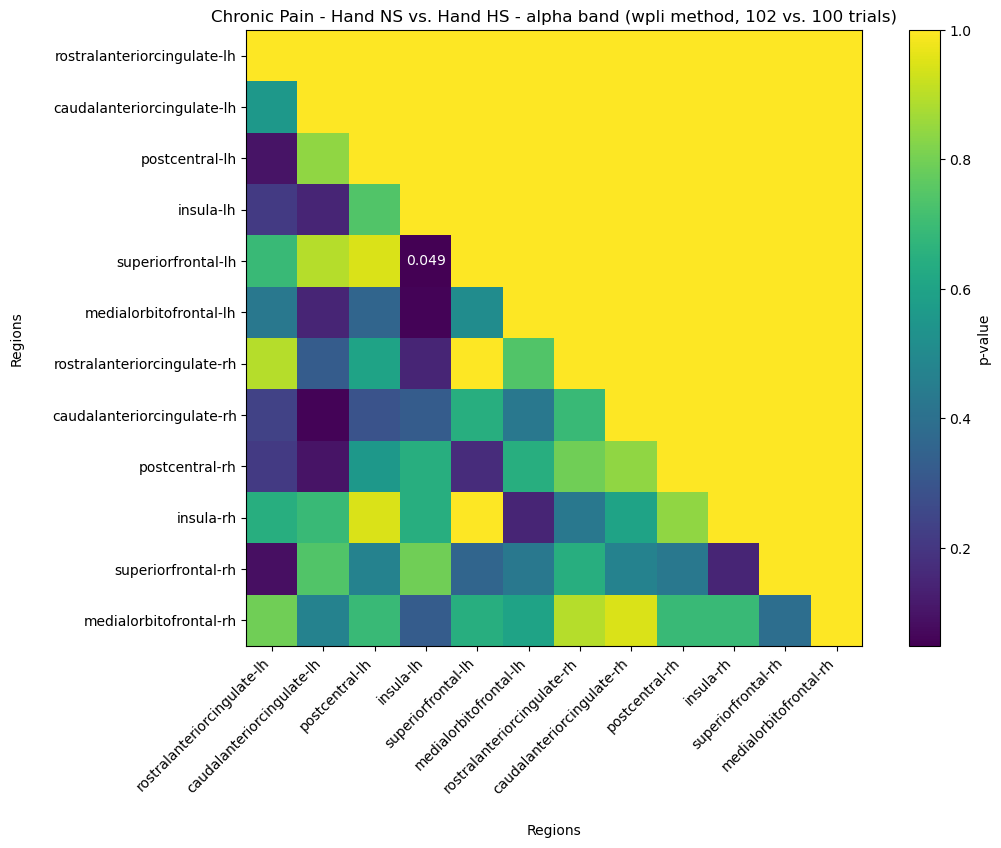

Chronic Pain - Hand NS vs. Hand HS - wpli2_debiased - low-gamma
Number of epochs in Chronic Pain Hand NS = 102
Number of epochs in Chronic Pain Hand NS = 100


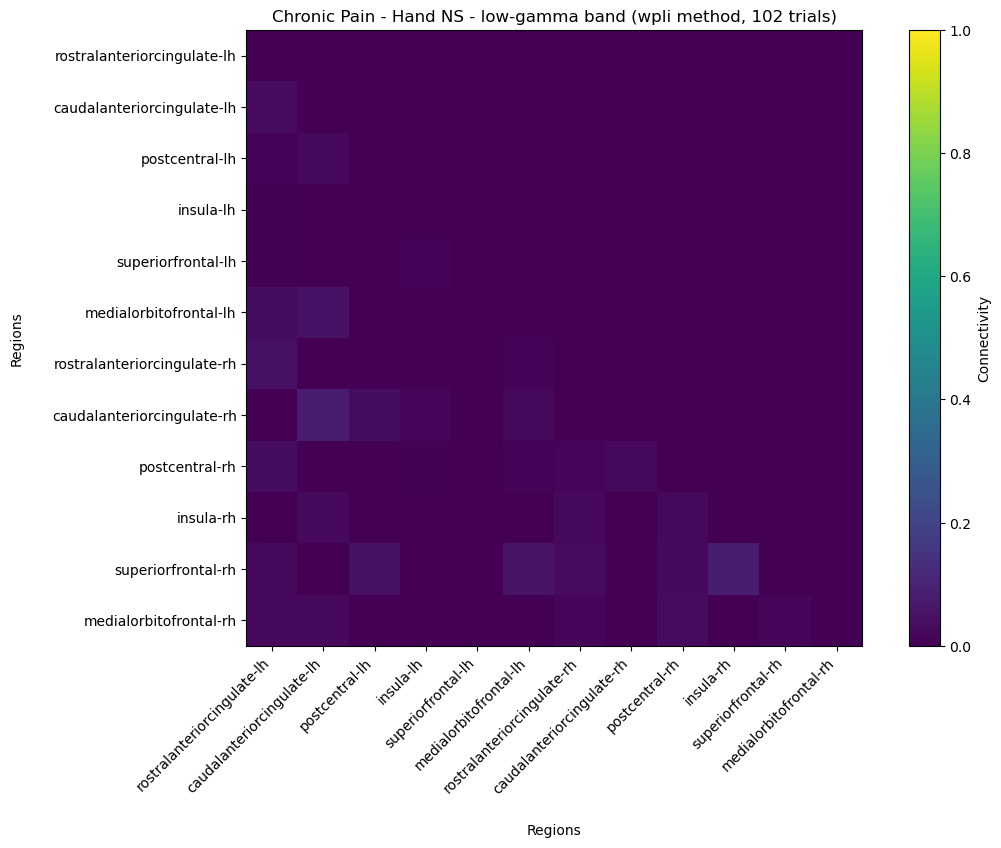

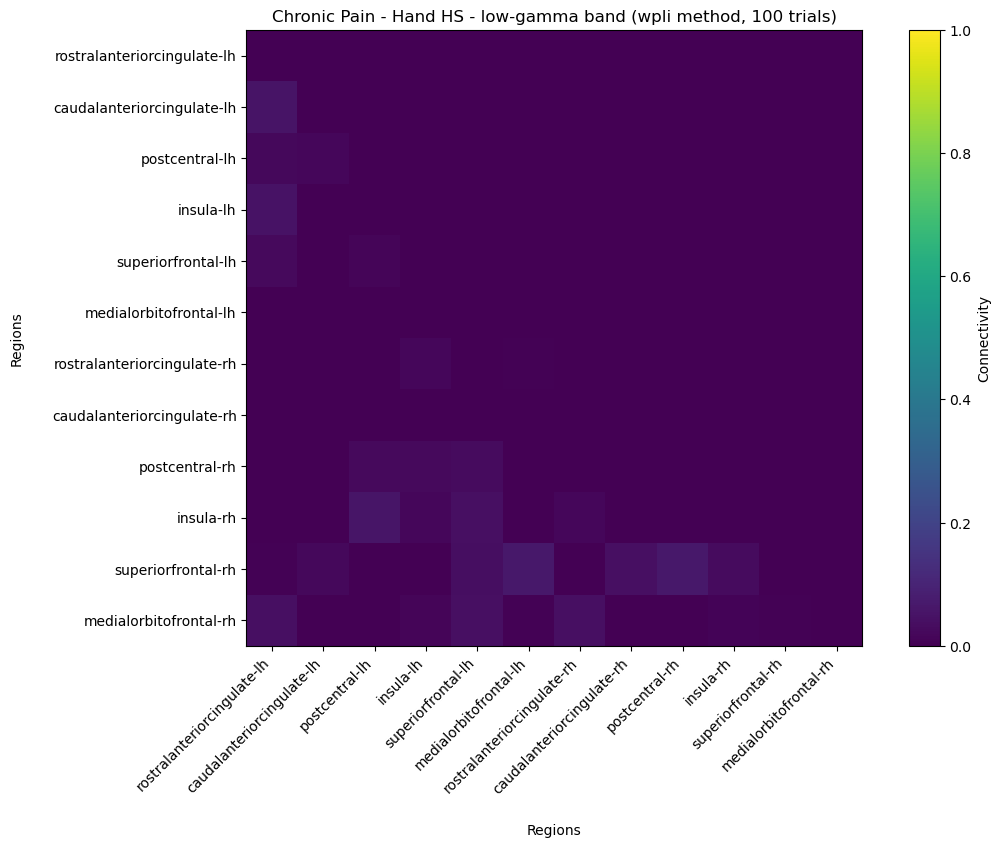

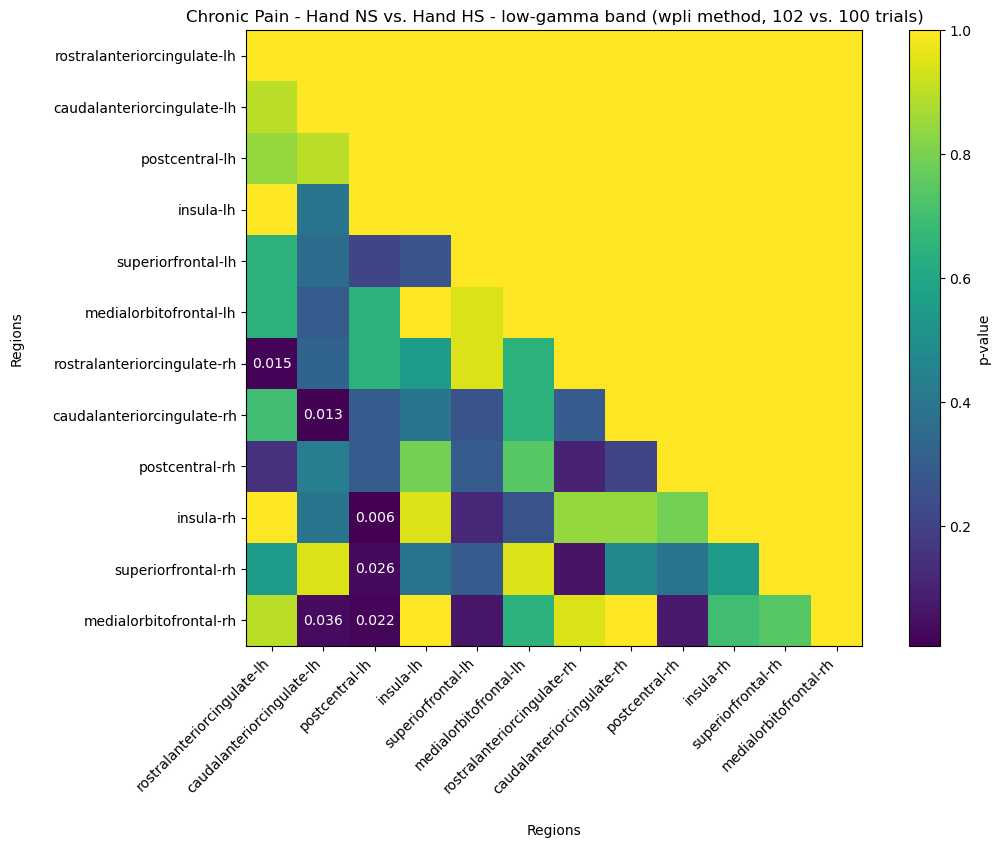

Chronic Pain - Hand NS vs. Hand HS - wpli2_debiased - high-gamma
Number of epochs in Chronic Pain Hand NS = 102
Number of epochs in Chronic Pain Hand NS = 100


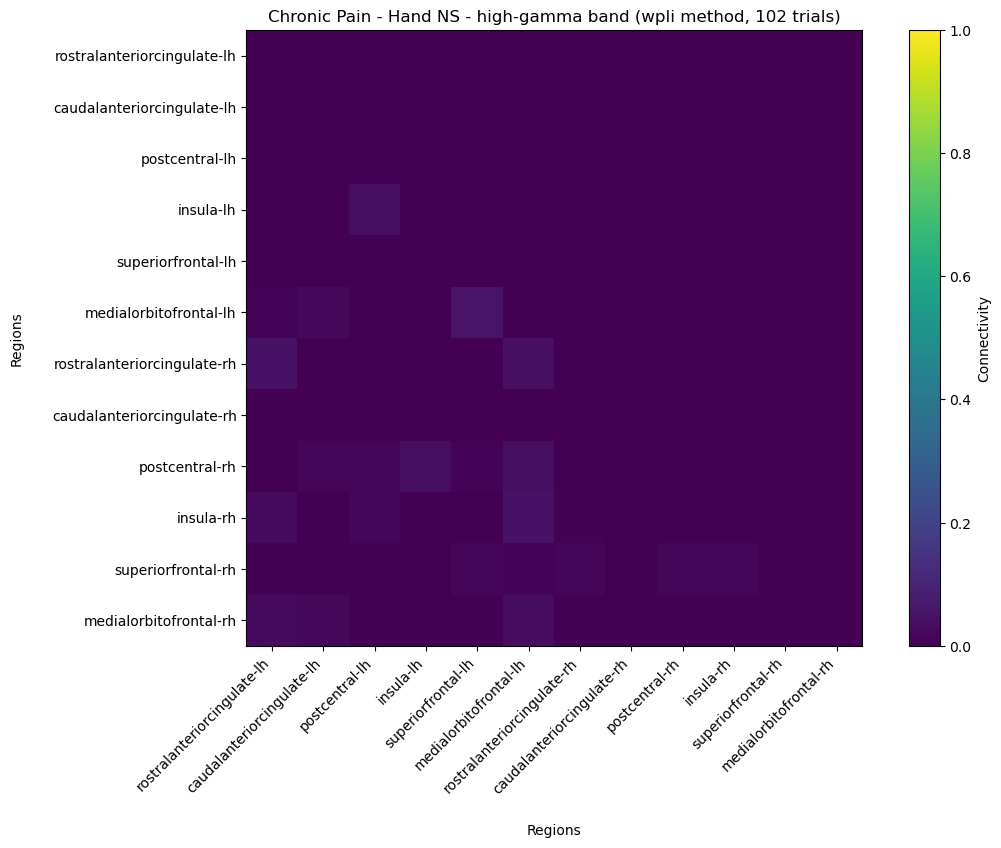

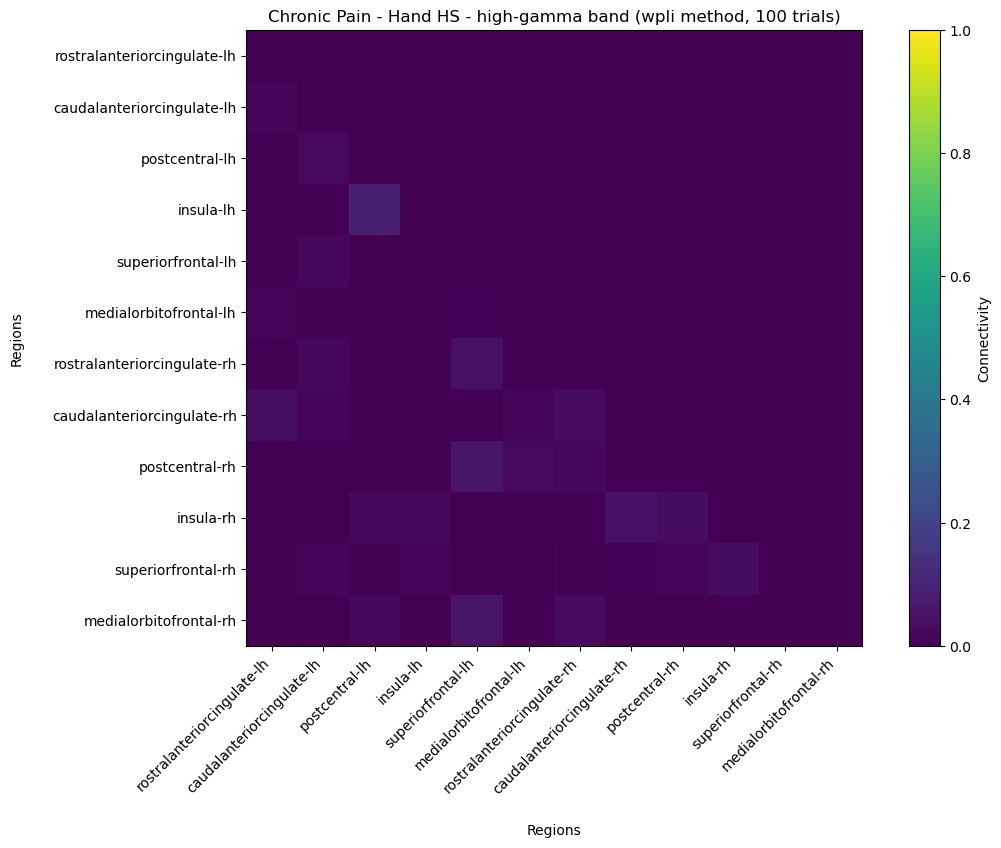

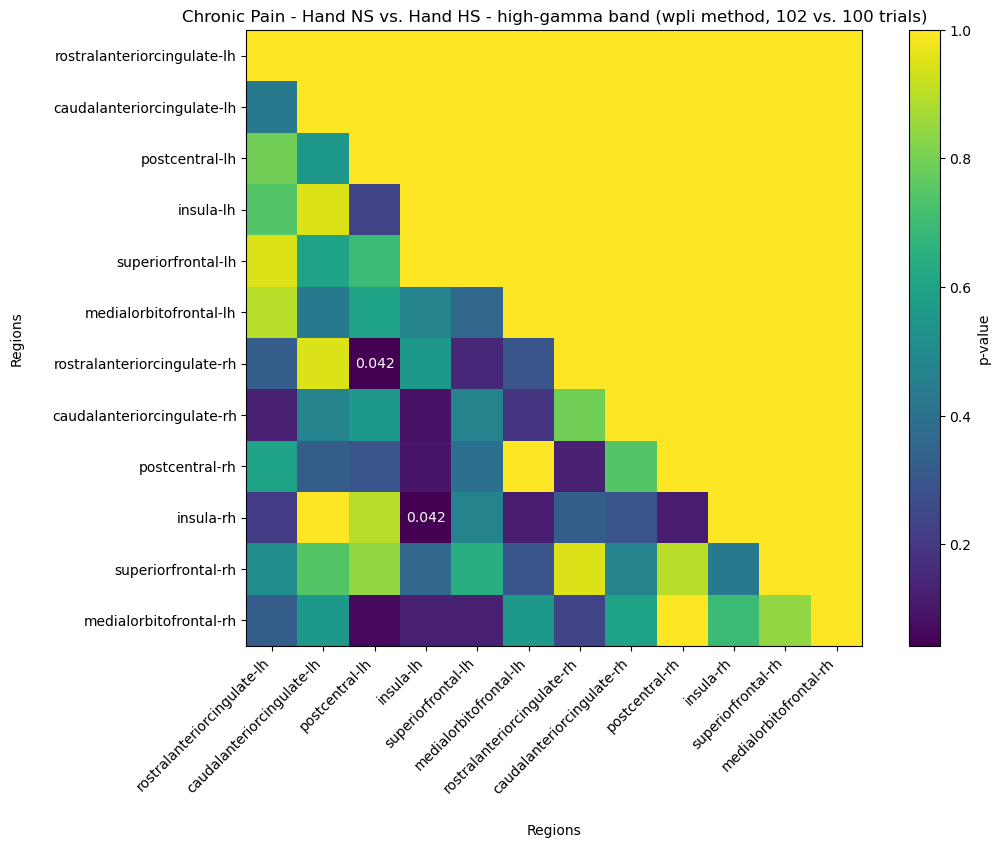

Healthy Control - Hand NS vs. Hand HS - wpli2_debiased - theta
Number of epochs in Healthy Control Hand NS = 176
Number of epochs in Healthy Control Hand NS = 176


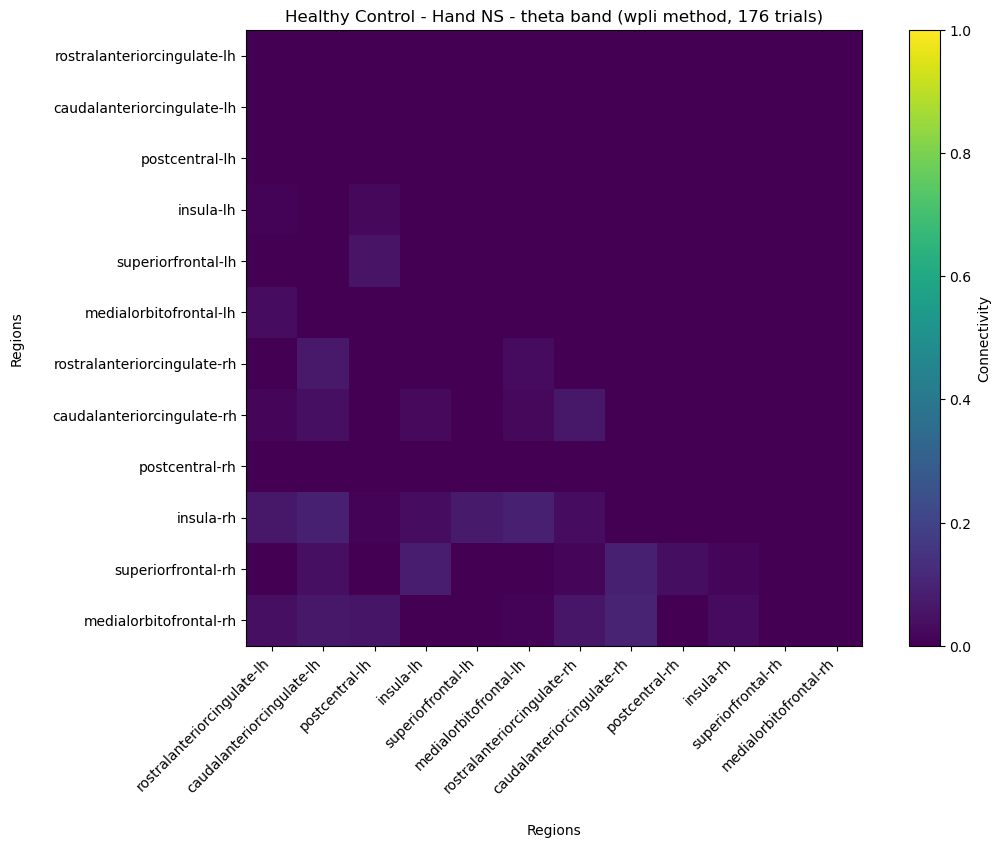

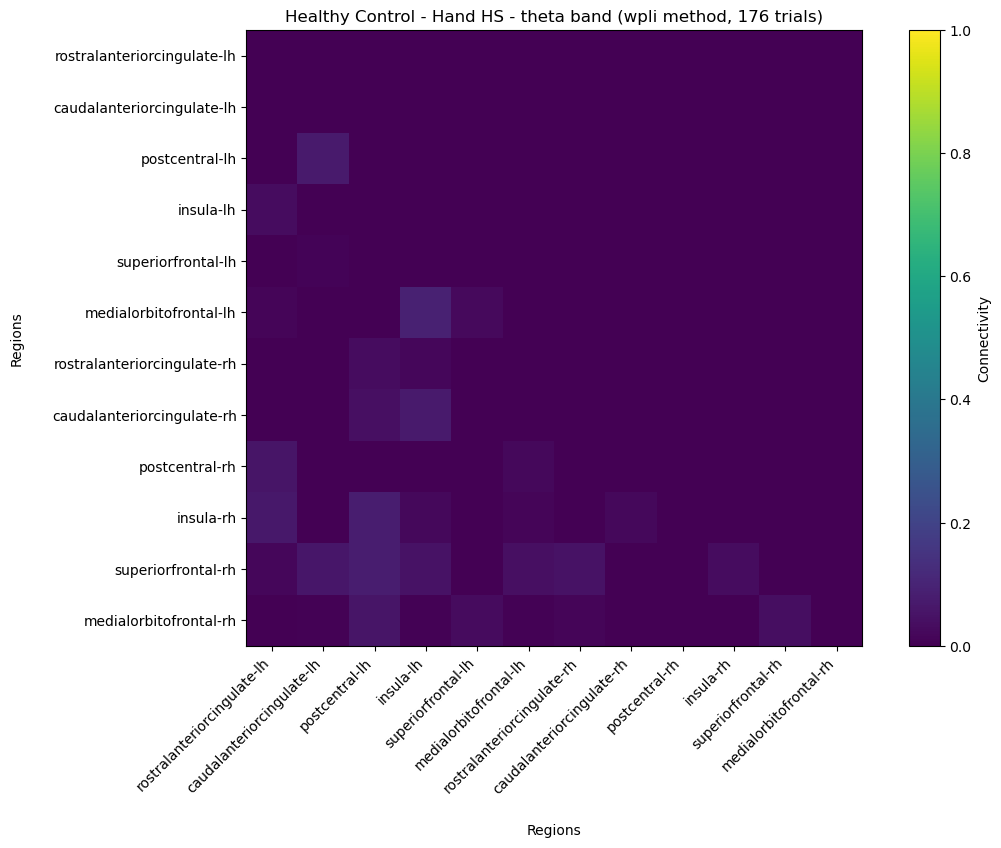

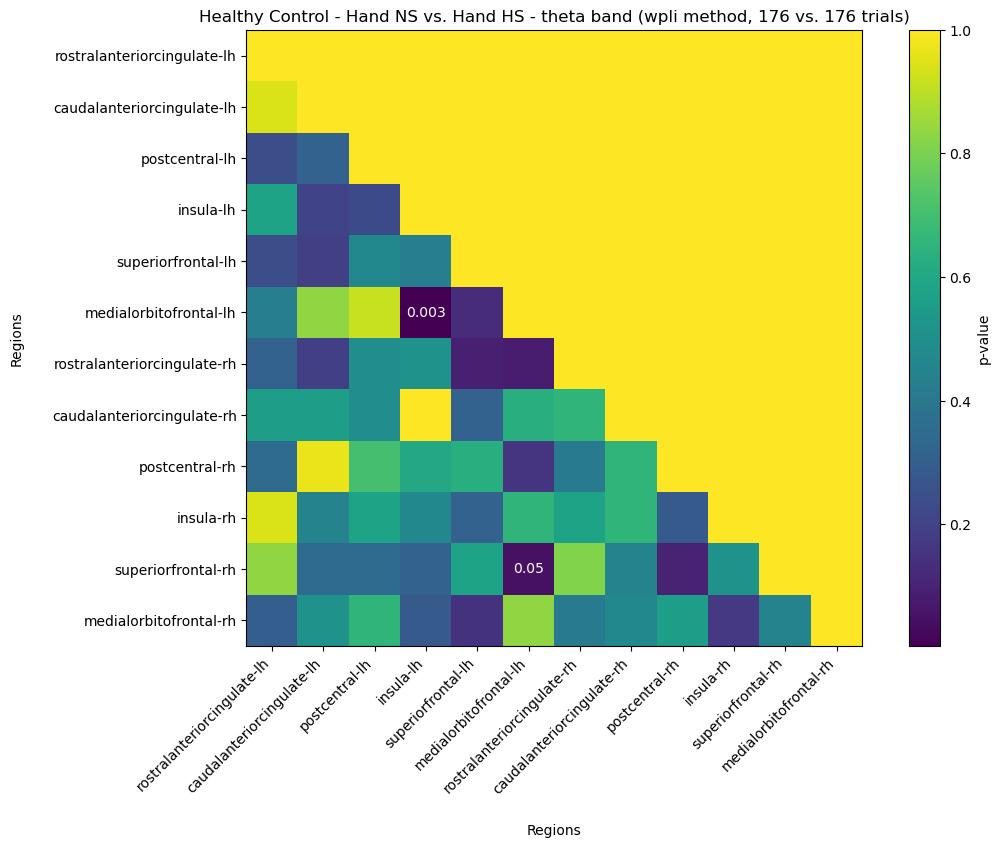

Healthy Control - Hand NS vs. Hand HS - wpli2_debiased - alpha
Number of epochs in Healthy Control Hand NS = 176
Number of epochs in Healthy Control Hand NS = 176


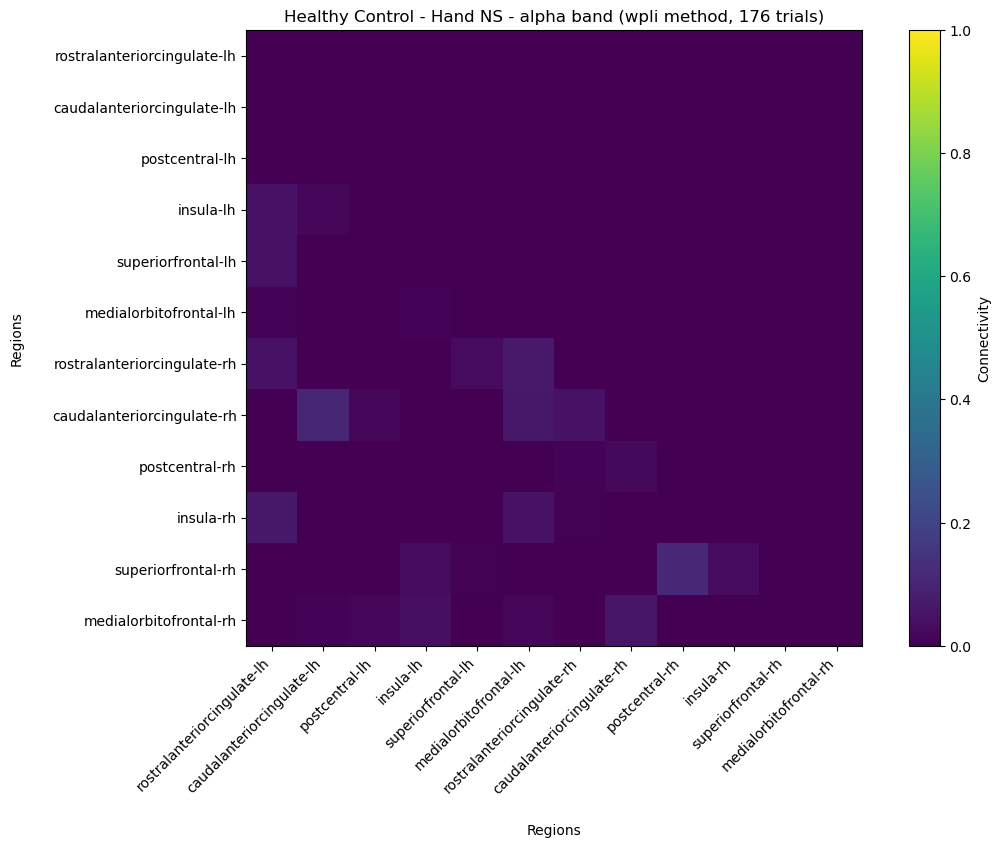

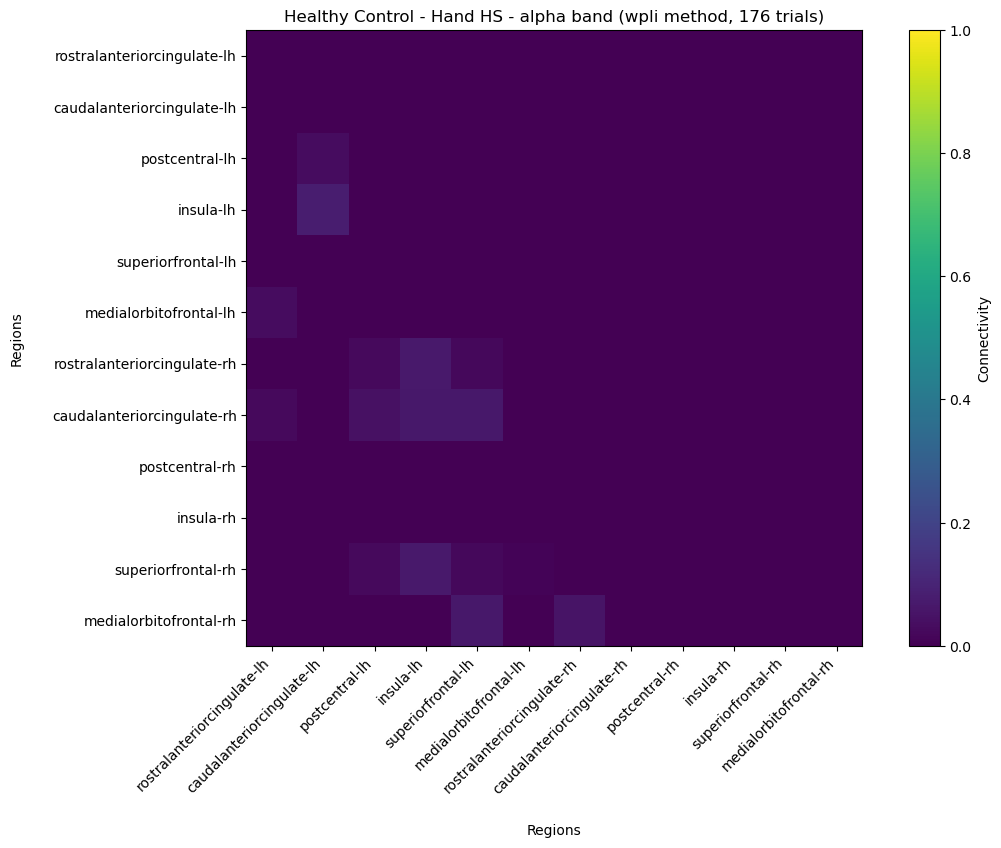

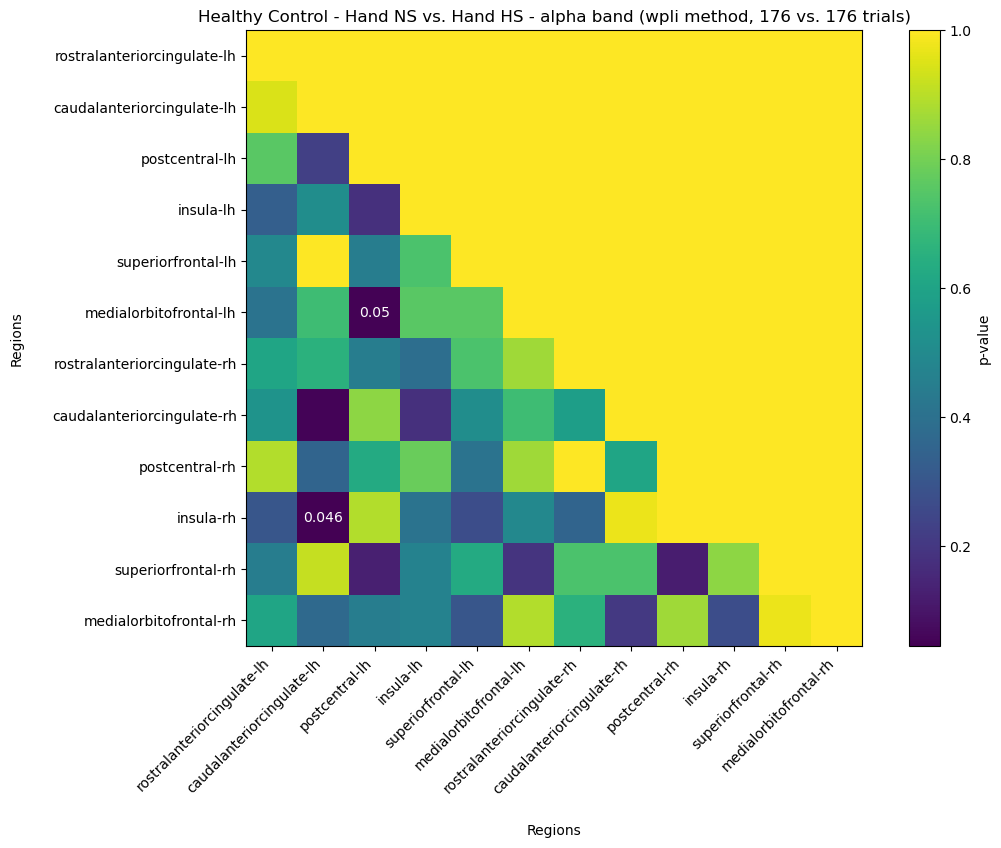

Healthy Control - Hand NS vs. Hand HS - wpli2_debiased - low-gamma
Number of epochs in Healthy Control Hand NS = 176
Number of epochs in Healthy Control Hand NS = 176


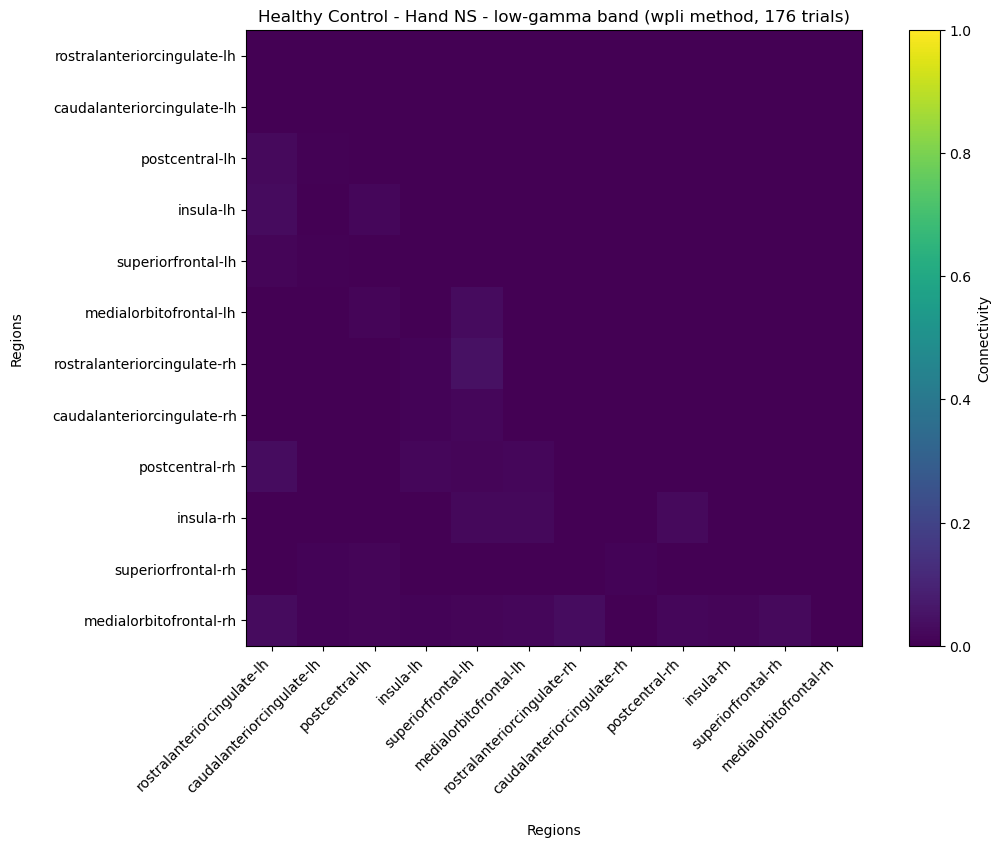

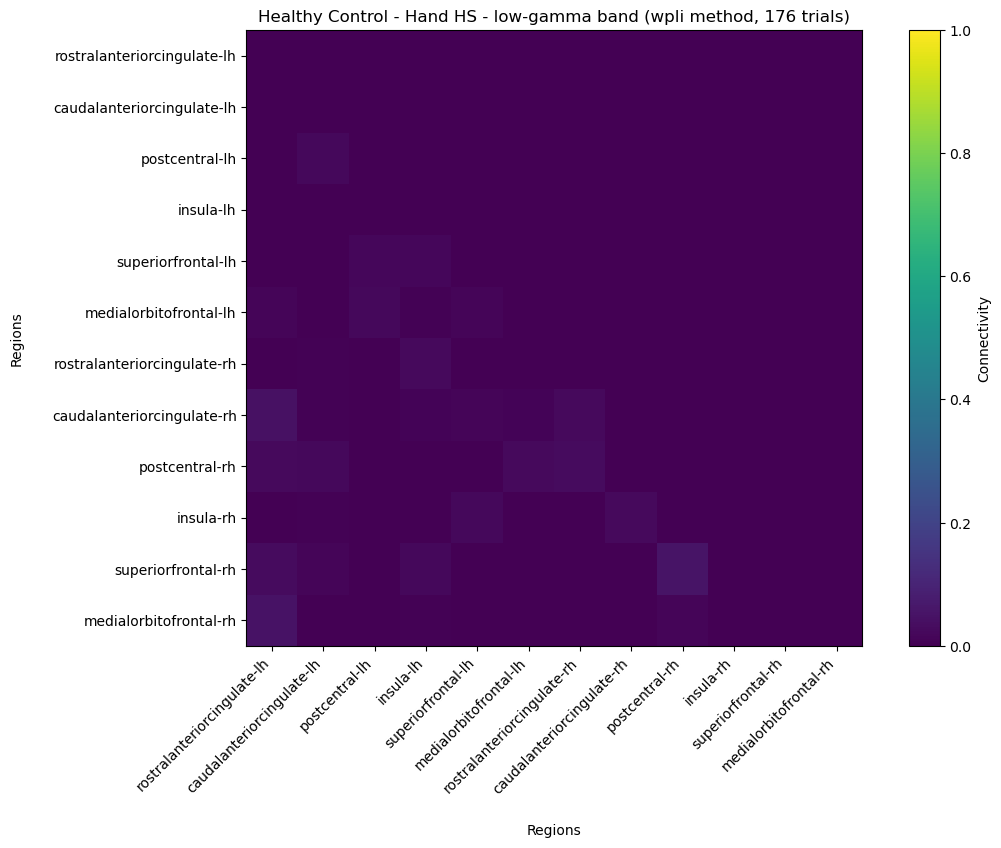

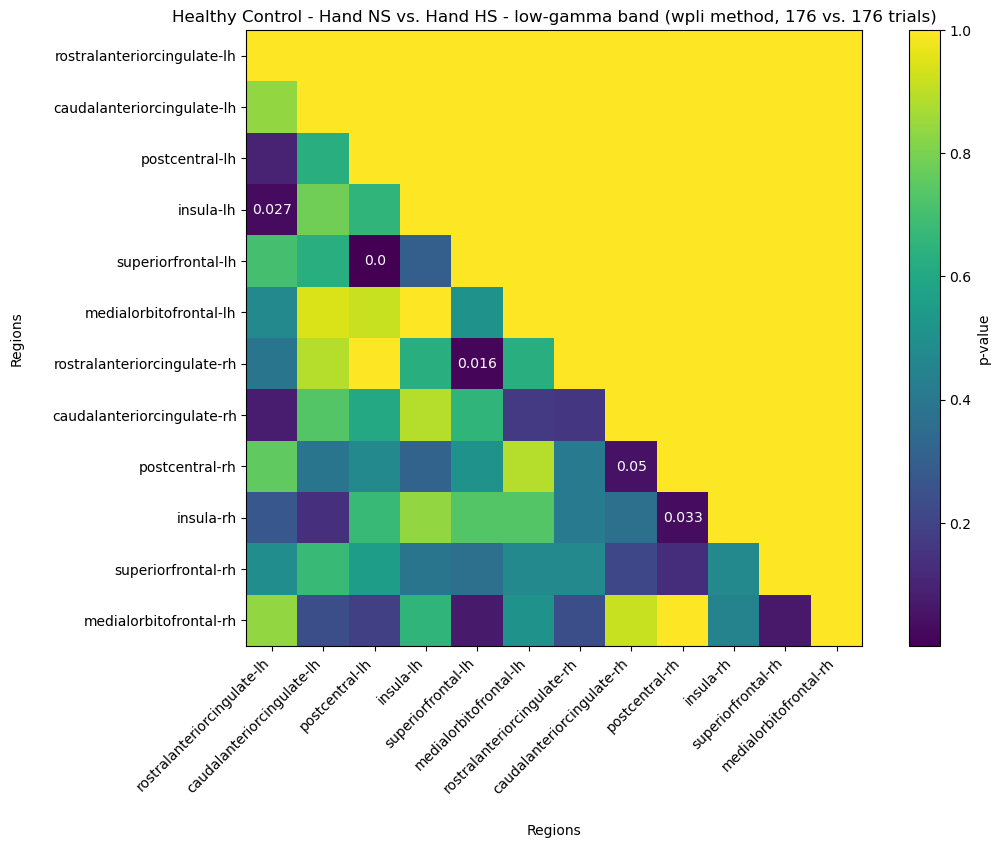

Healthy Control - Hand NS vs. Hand HS - wpli2_debiased - high-gamma
Number of epochs in Healthy Control Hand NS = 176
Number of epochs in Healthy Control Hand NS = 176


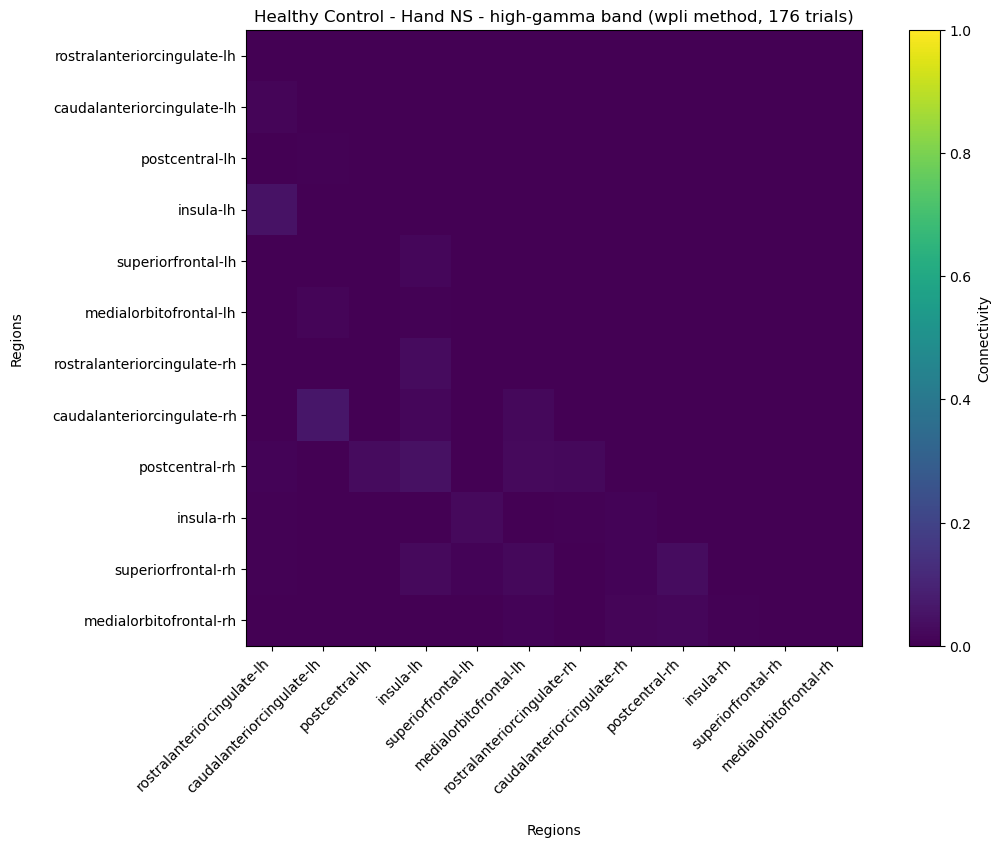

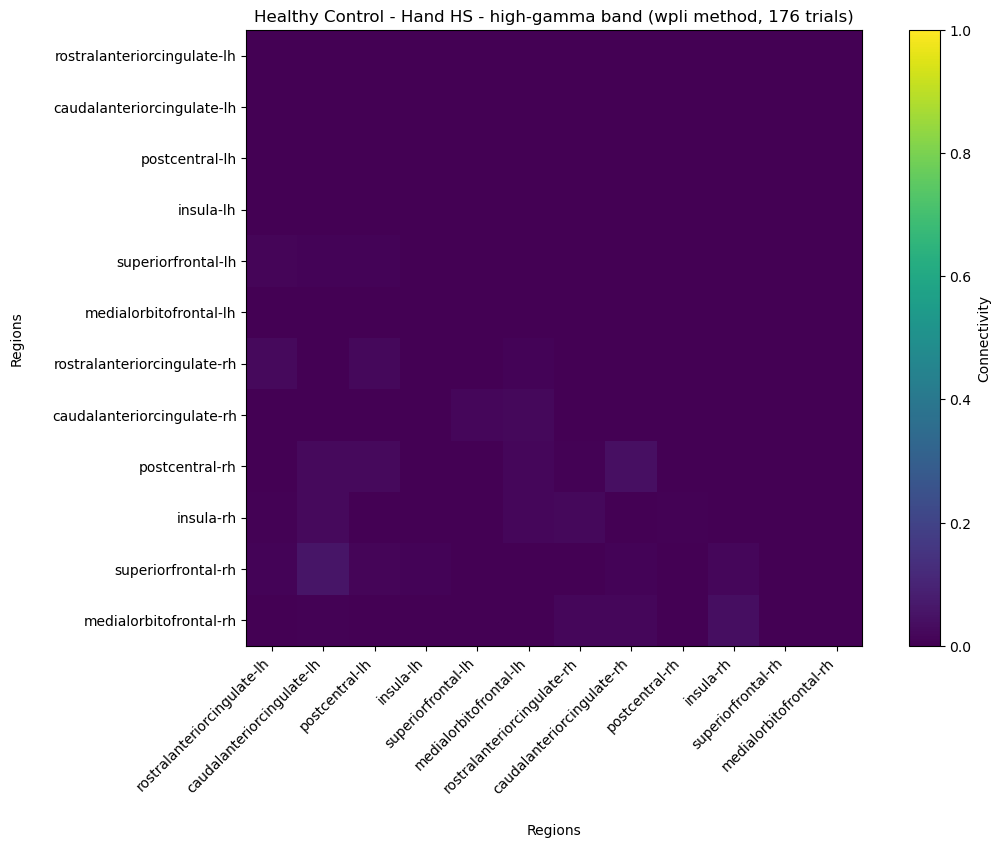

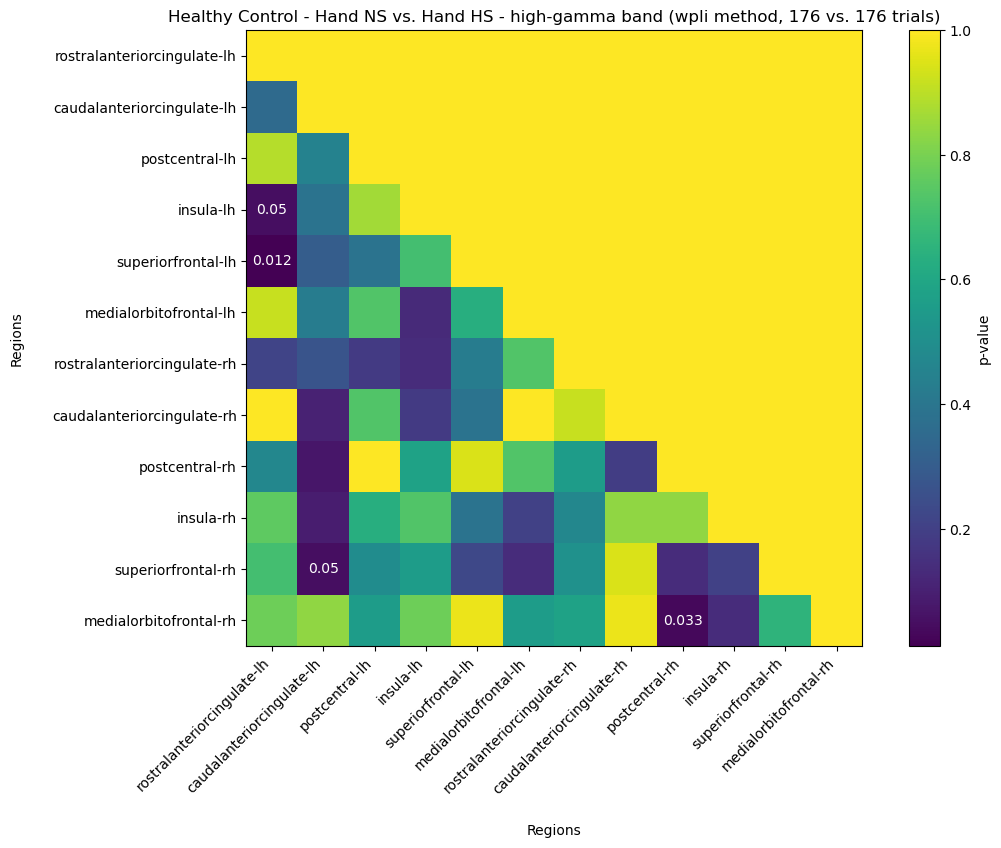

In [10]:
# 1. Hand NS vs. HS within group comparison
cond1 = "Hand NS"
cond2 = "Hand HS"

stats_save_path = save_path / f"{cond1}_vs_{cond2}_within_group"
os.makedirs(stats_save_path, exist_ok=True)

for group_name, group in zip(groups, [group_con_CP, group_con_HC]):
    for method in con_methods:
        for band in band_names:

            # Select groups for mann-whitney
            print(f"{group_name} - {cond1} vs. {cond2} - {method} - {band}")
            group1_stack = group[cond1][method][band]
            group2_stack = group[cond2][method][band]

            nepochs_1 = group[cond1]['num_epochs']
            nepochs_2 = group[cond2]['num_epochs']
            print(f"Number of epochs in {group_name} {cond1} = {nepochs_1}")
            print(f"Number of epochs in {group_name} {cond1} = {nepochs_2}")
            
            # Compute the Mann-Whitney U test
            p_values, means_1, sem_1, means_2, sem_2 = fc.mann_whitney_test(
                group1_stack, group2_stack,roi_names)

            # Plotting            
            # Gather the information for plotting
            plot_kwargs= dict(
                method=method, band=band, 
                roi_names=roi_names,
                group_name=group_name)
            
            fc.plot_connectivity(means_1, 
                                 **plot_kwargs, 
                                 condition=cond1, 
                                 num_epochs=nepochs_1, 
                                 save_path=stats_save_path)
            
            fc.plot_connectivity(means_2, 
                                 **plot_kwargs, 
                                 condition=cond2, 
                                 num_epochs=nepochs_2, 
                                 save_path=stats_save_path)
            fc.plot_connectivity(p_values, 
                                 **plot_kwargs, 
                                 condition="p-values", 
                                 num_epochs=f"{nepochs_1} vs. {nepochs_2}", 
                                 save_path=stats_save_path,
                                 title_prefix=f"{group_name} - {cond1} vs. {cond2}",                                 save_fig=True)
            
            # fc.plot_connectivity_circle(con_data, **plot_kwargs, save_path=save_path)

Hand HS - H vs. e - wpli2_debiased - theta
Number of epochs in H Hand HS = 100
Number of epochs in e Hand HS = 100


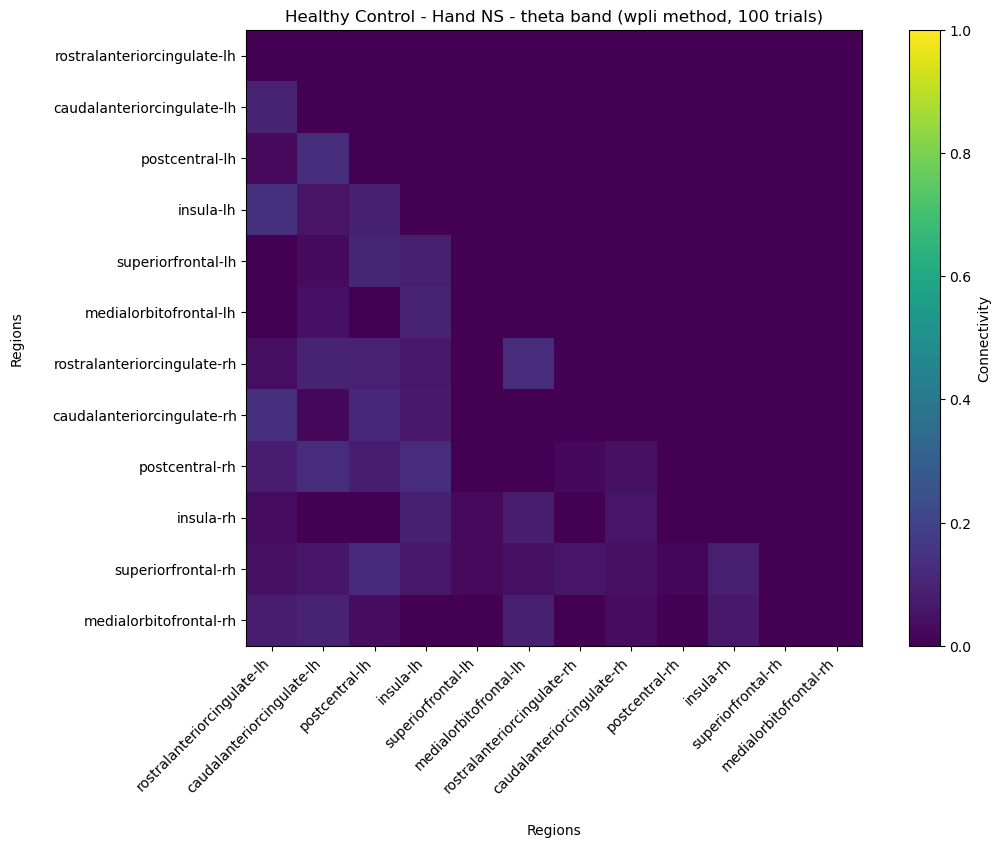

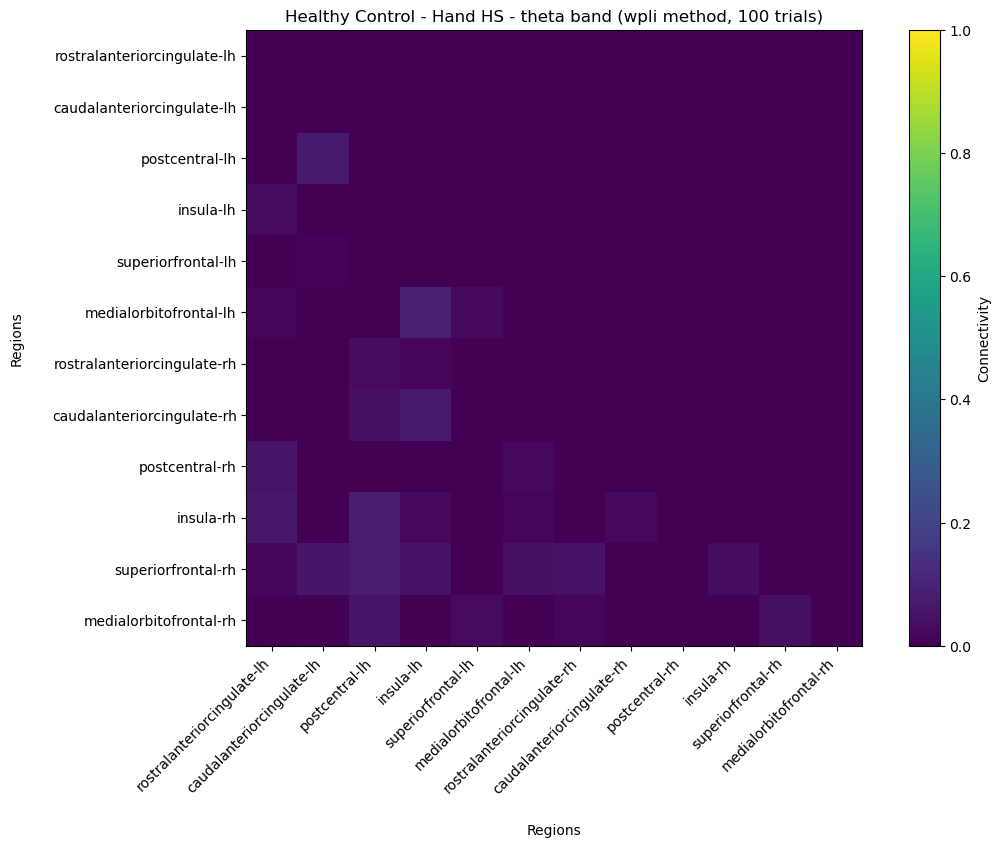

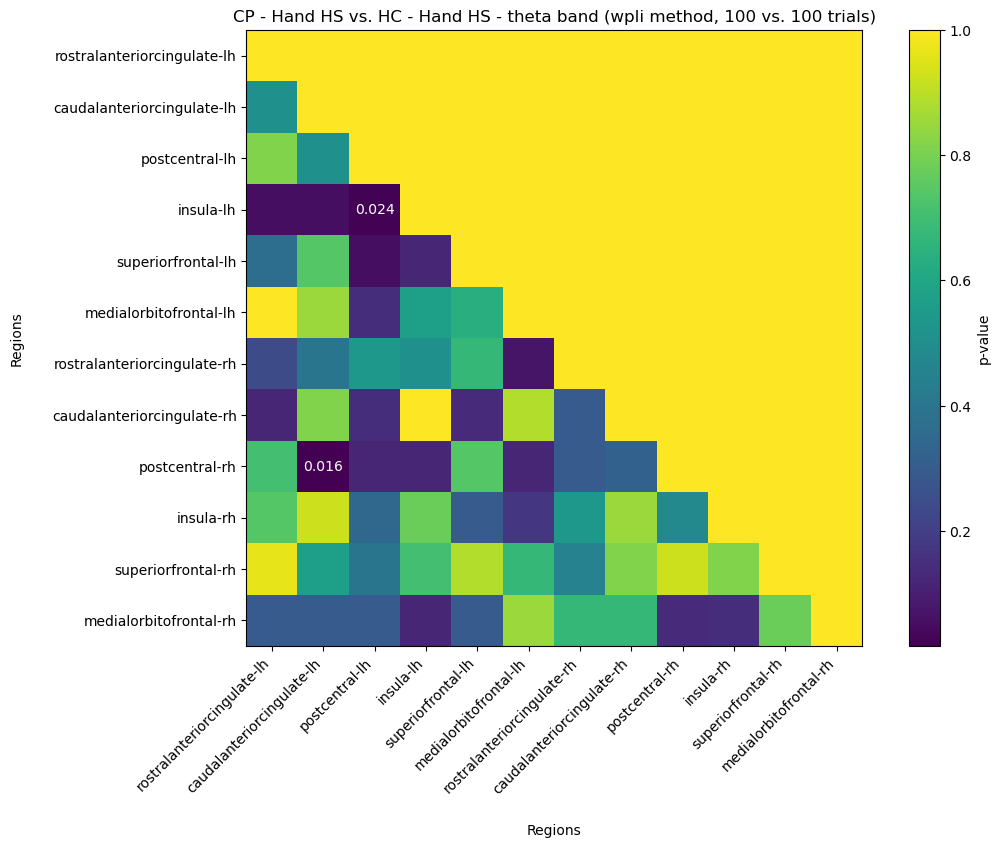

Hand HS - H vs. e - wpli2_debiased - alpha
Number of epochs in H Hand HS = 100
Number of epochs in e Hand HS = 100


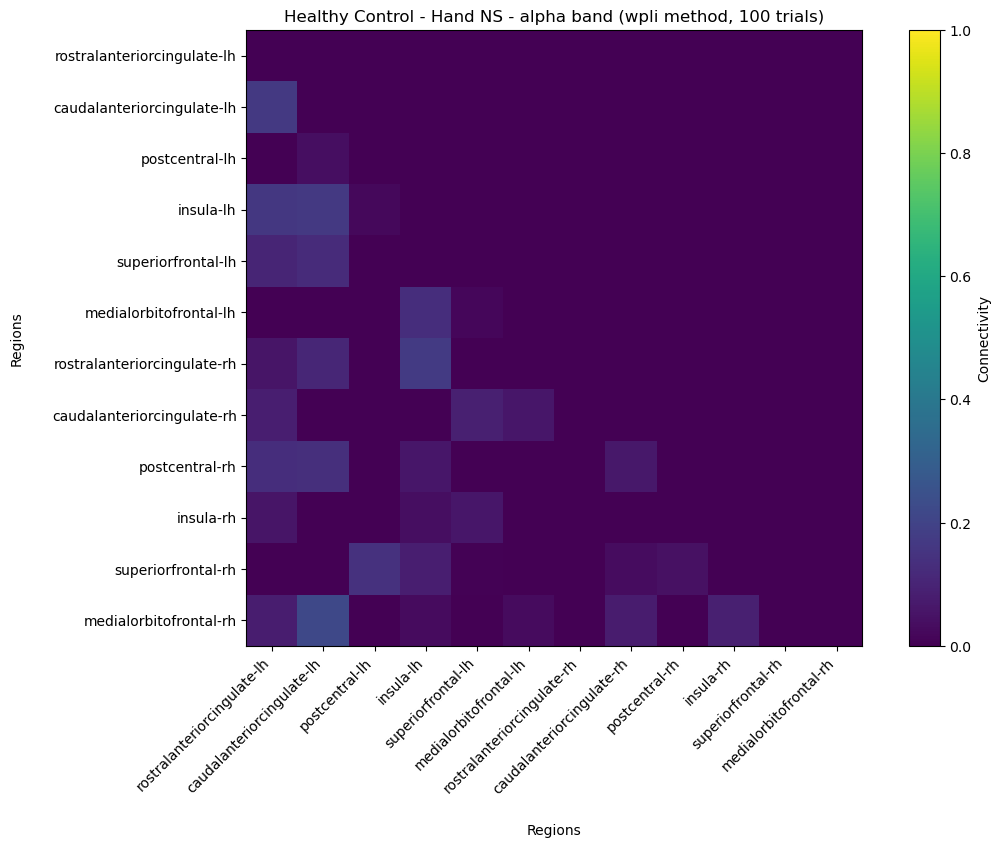

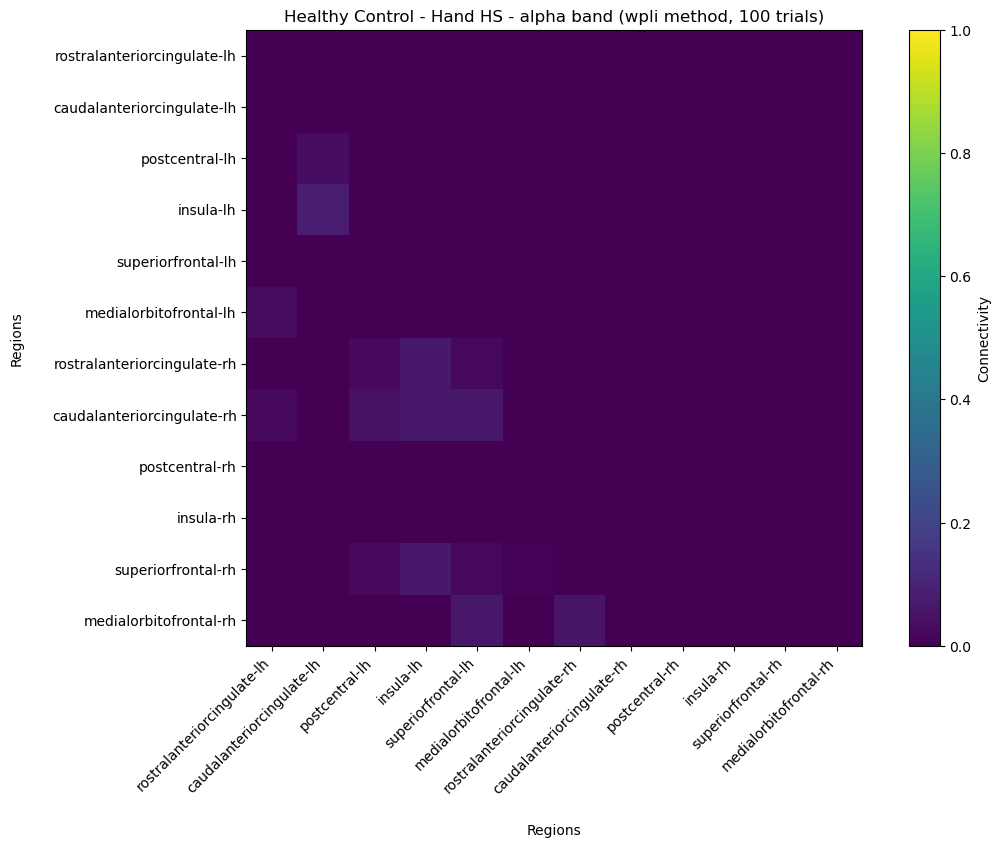

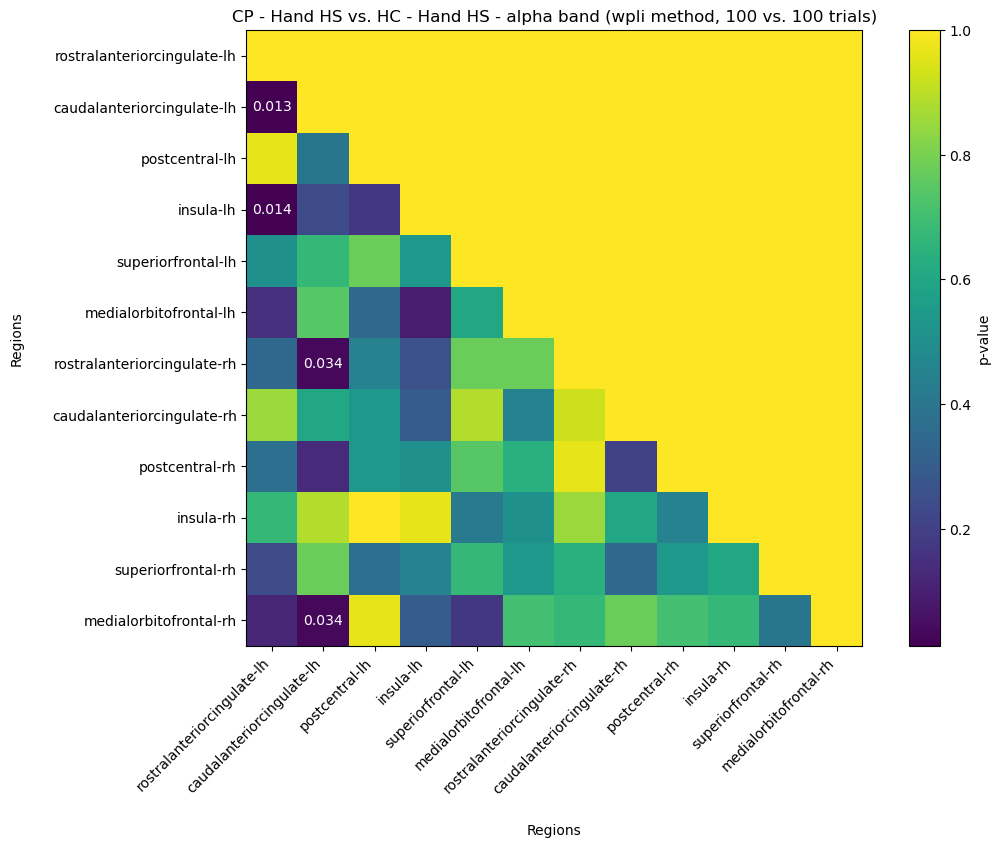

Hand HS - H vs. e - wpli2_debiased - low-gamma
Number of epochs in H Hand HS = 100
Number of epochs in e Hand HS = 100


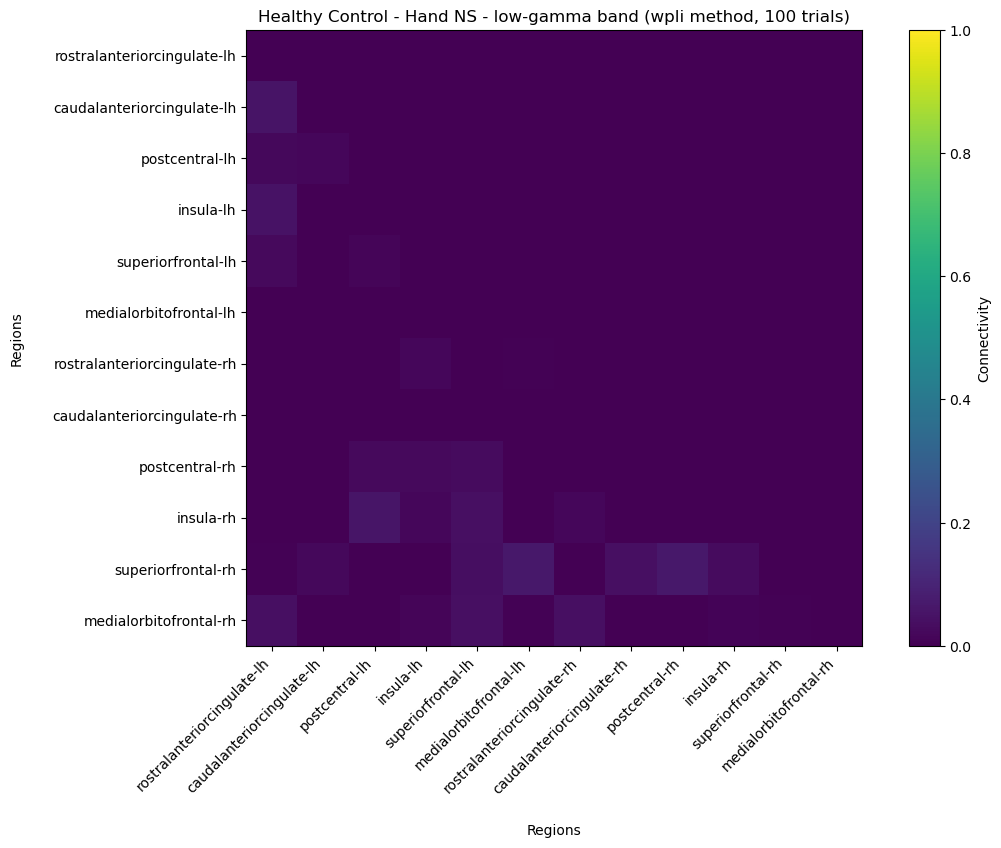

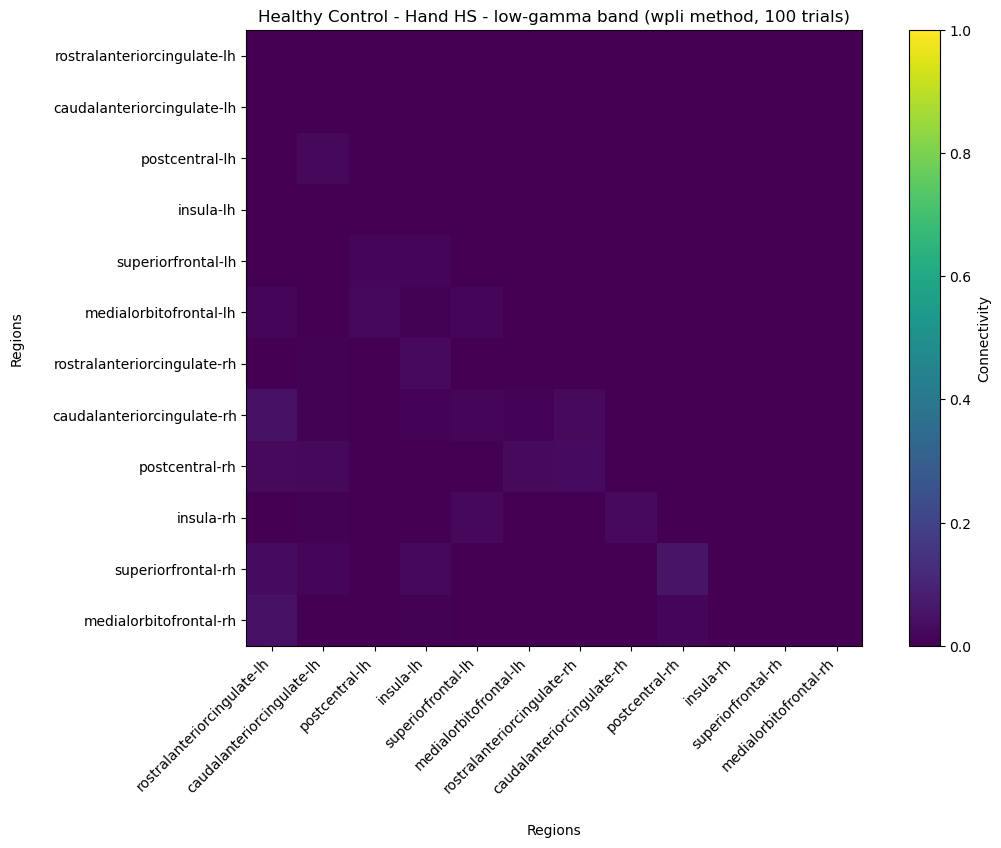

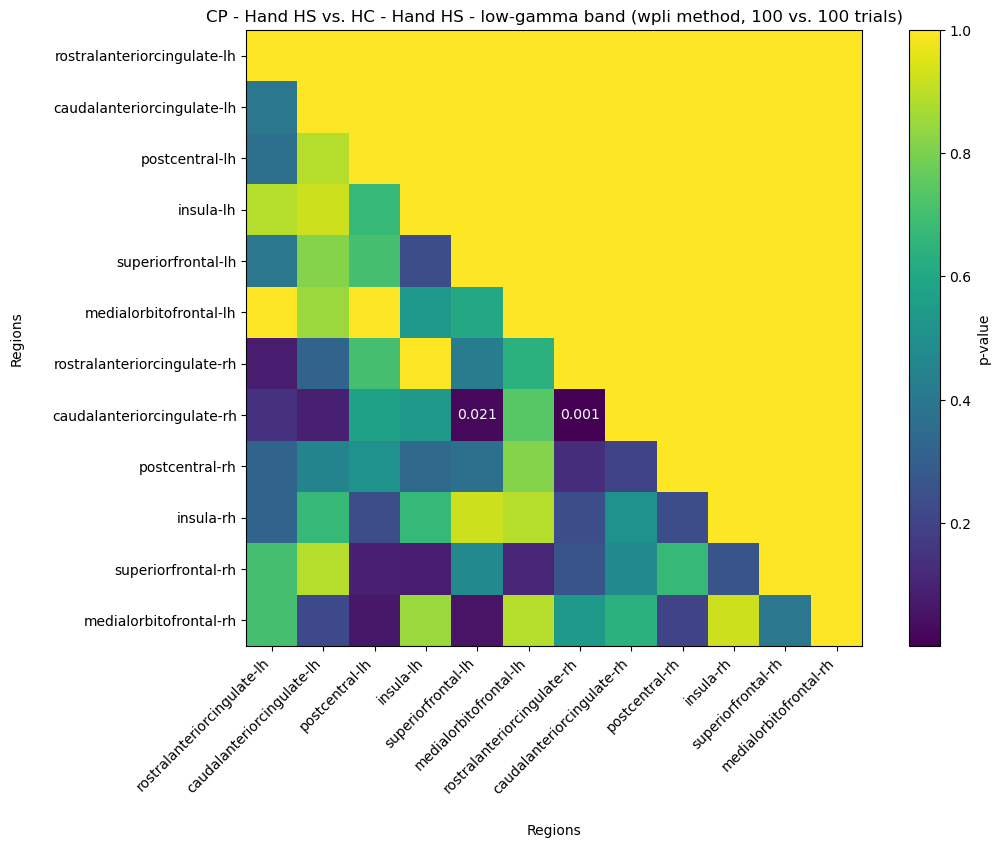

Hand HS - H vs. e - wpli2_debiased - high-gamma
Number of epochs in H Hand HS = 100
Number of epochs in e Hand HS = 100


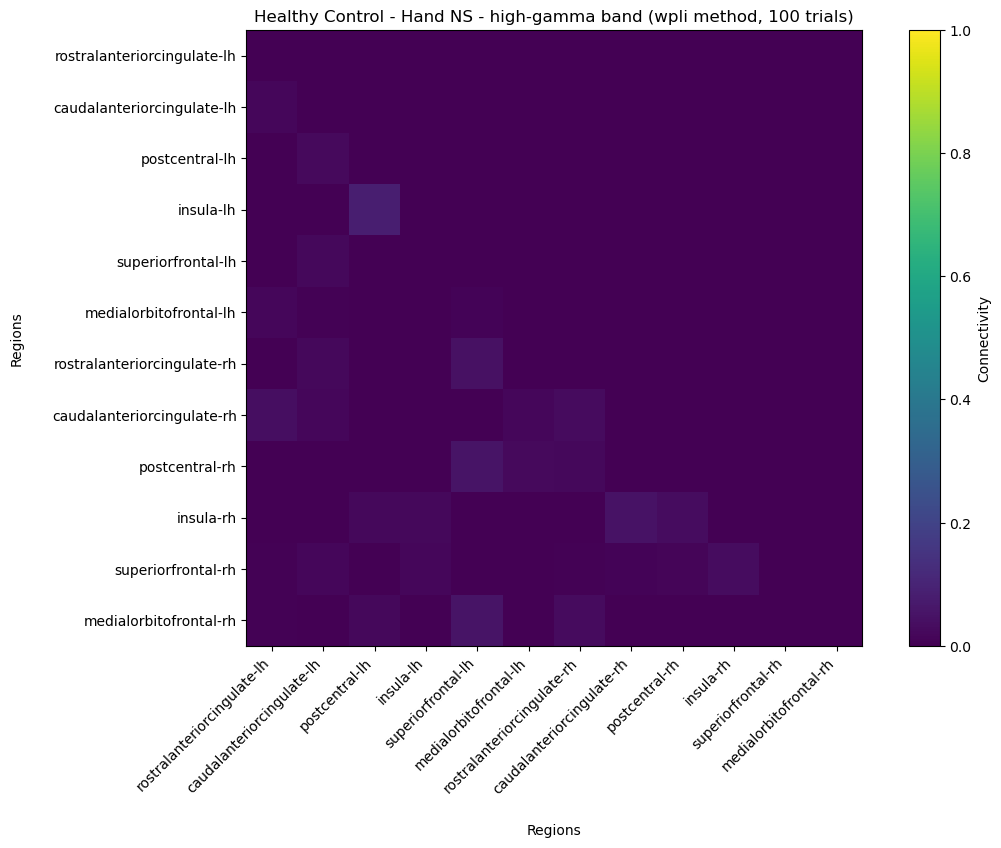

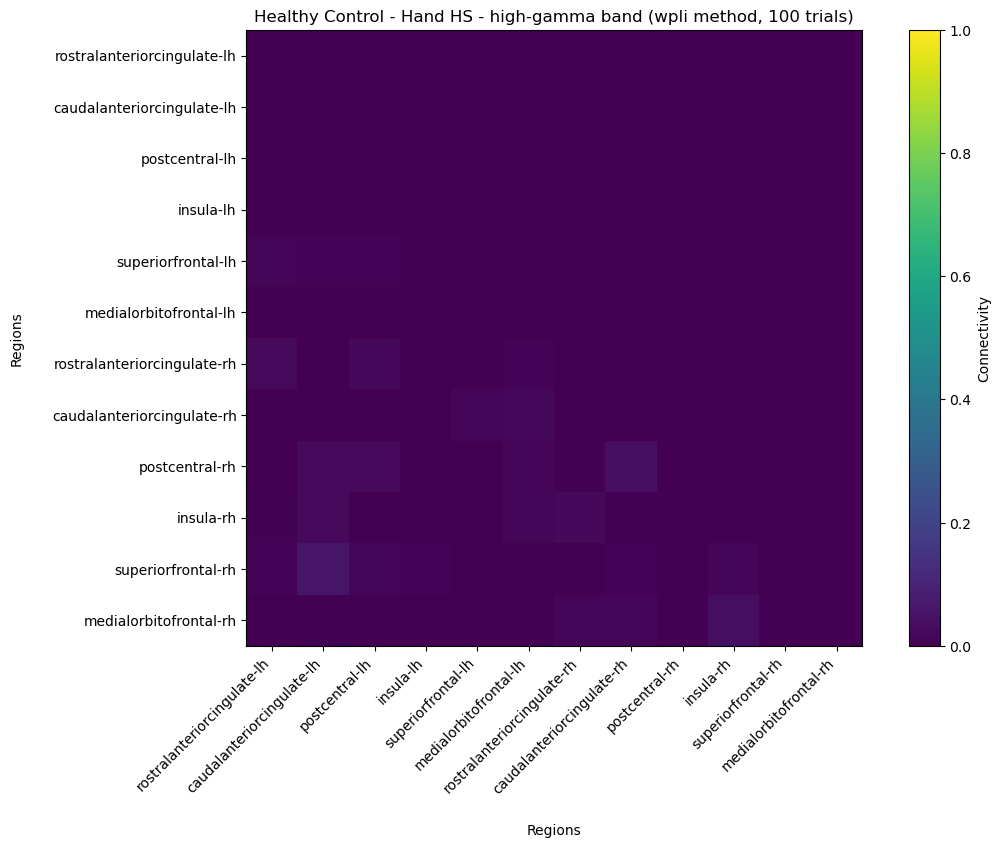

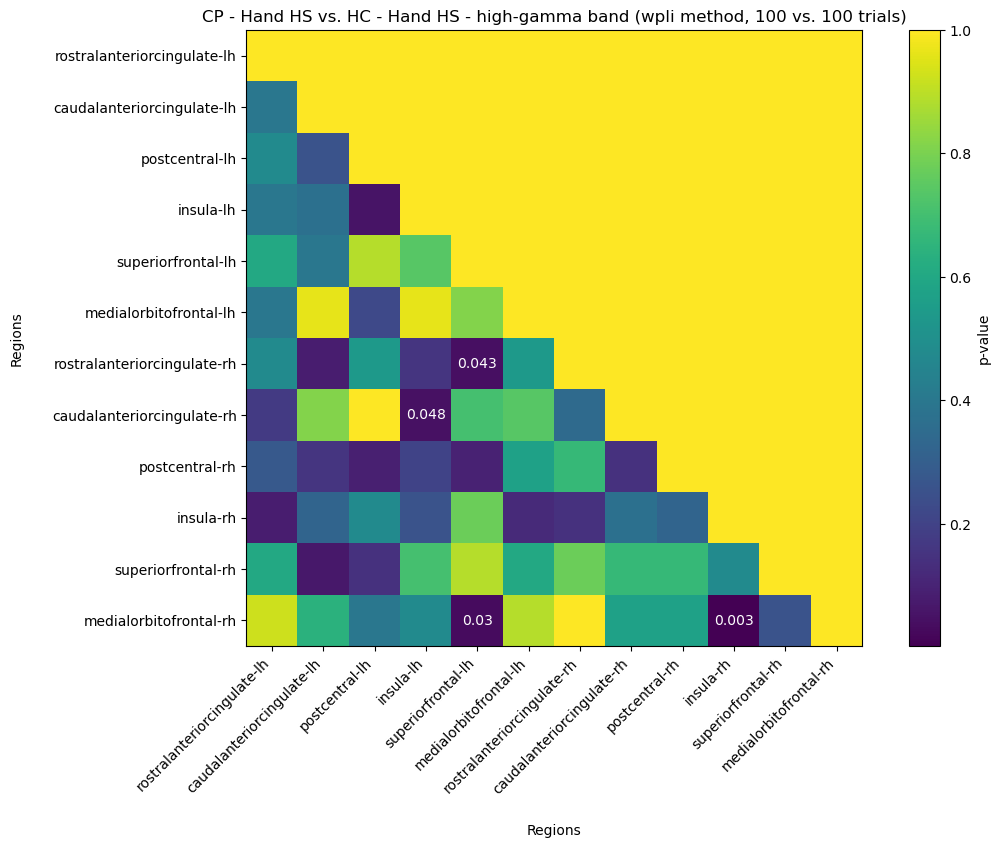

In [11]:
# 2. CP Widespread Pain Hand HS. vs Healthy Control Hand HS
condition = "Hand HS"
stats_save_path = save_path / "CP_WS_vs_HC_Hand_HS"
os.makedirs(stats_save_path, exist_ok=True)

for method in con_methods:
    for band in band_names:
        # Select groups for mann-whitney
        print(f"{condition} - {group_name[0]} vs. {group_name[1]} - {method} - {band}")
        group1_stack = group_con_CP[condition][method][band]
        group2_stack = group_con_HC[condition][method][band]

        nepochs_1 = group_con_CP[condition]['num_epochs']
        nepochs_2 = group_con_CP[condition]['num_epochs']
        print(f"Number of epochs in {group_name[0]} {condition} = {nepochs_1}")
        print(f"Number of epochs in {group_name[1]} {condition} = {nepochs_2}")
        
        # Compute the Mann-Whitney U test
        p_values, means_1, sem_1, means_2, sem_2 = fc.mann_whitney_test(
            group1_stack, group2_stack,roi_names)

        # Plotting            
        # Gather the information for plotting
        plot_kwargs= dict(
            method=method, band=band, 
            roi_names=roi_names,
            group_name=group_name)
        
        fc.plot_connectivity(means_1, 
                                **plot_kwargs, 
                                condition=cond1, 
                                num_epochs=nepochs_1, 
                                save_path=stats_save_path)
        
        fc.plot_connectivity(means_2, 
                                **plot_kwargs, 
                                condition=cond2, 
                                num_epochs=nepochs_2, 
                                save_path=stats_save_path)
        fc.plot_connectivity(p_values, 
                                **plot_kwargs, 
                                condition="p-values", 
                                num_epochs=f"{nepochs_1} vs. {nepochs_2}", 
                                save_path=stats_save_path,
                                title_prefix="CP - Hand HS vs. HC - Hand HS",
                                save_fig=True)
        
            # fc.plot_connectivity_circle(con_data, **plot_kwargs, save_path=save_path)

Hand HS - H vs. e - wpli2_debiased - theta
Number of epochs in H Hand HS = 100
Number of epochs in e Hand HS = 100


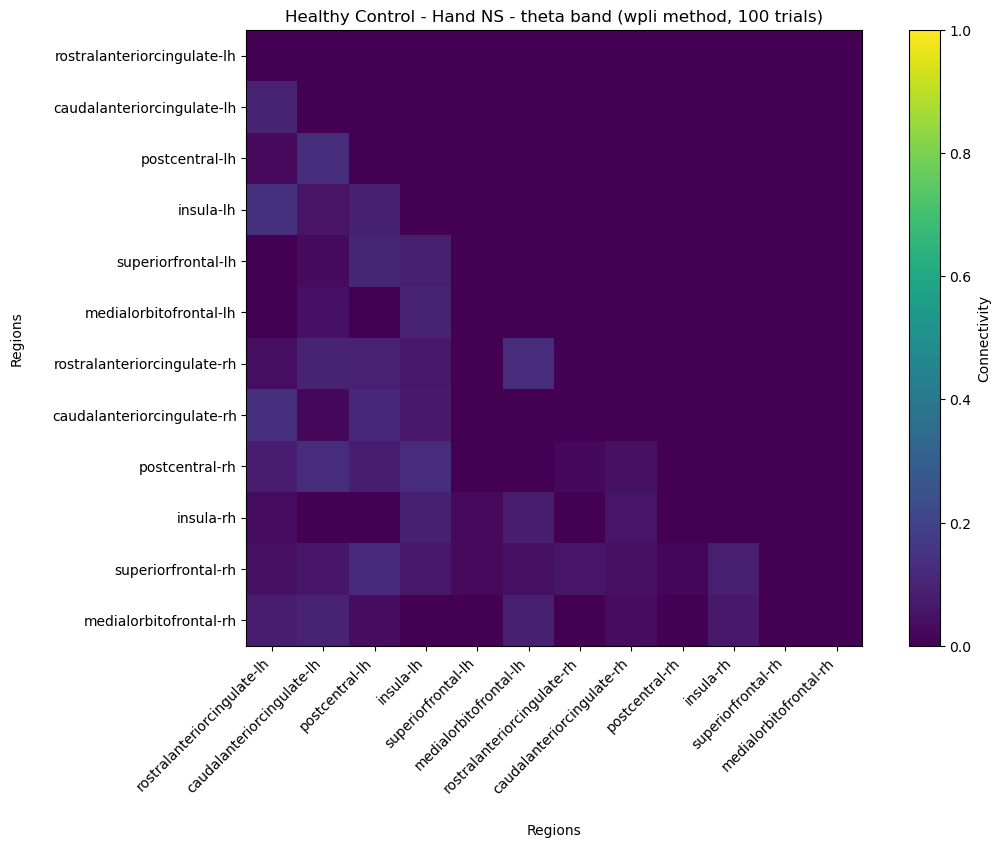

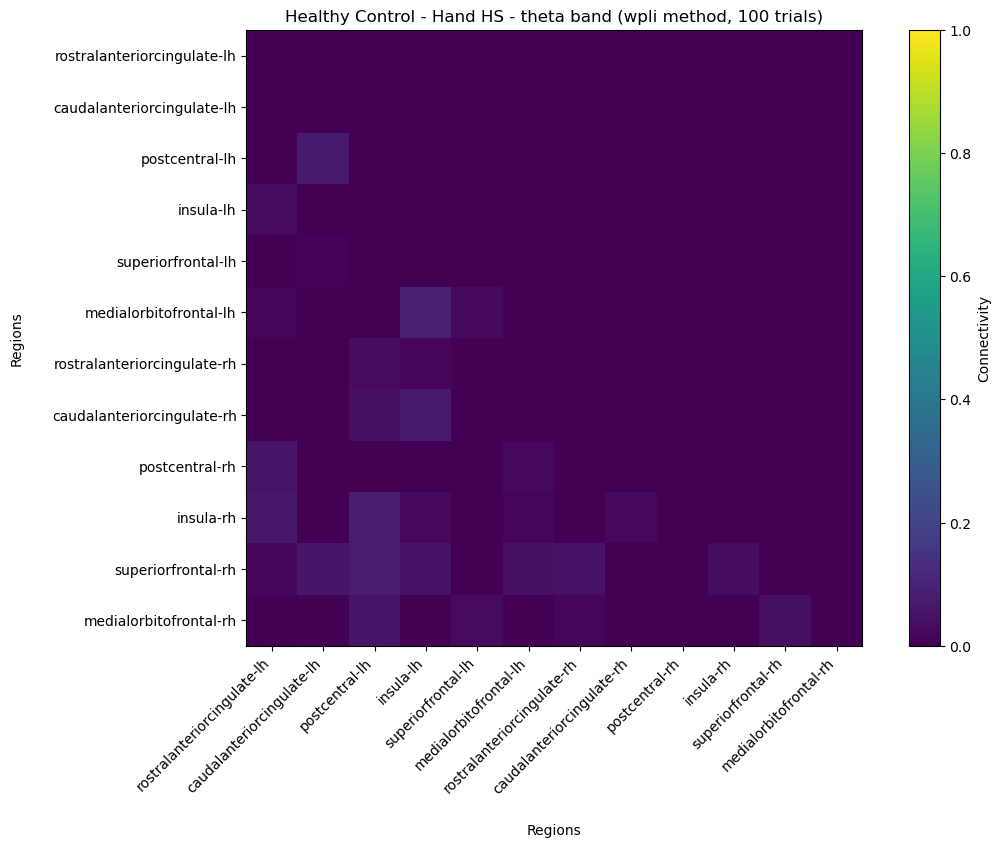

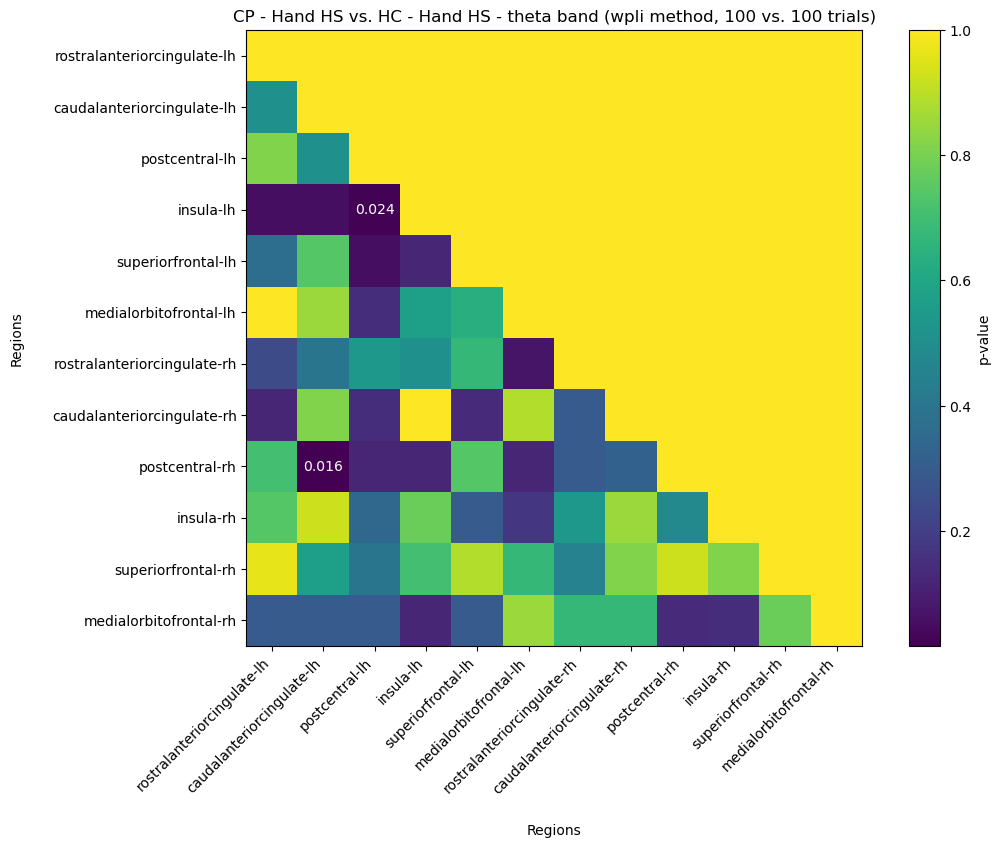

Hand HS - H vs. e - wpli2_debiased - alpha
Number of epochs in H Hand HS = 100
Number of epochs in e Hand HS = 100


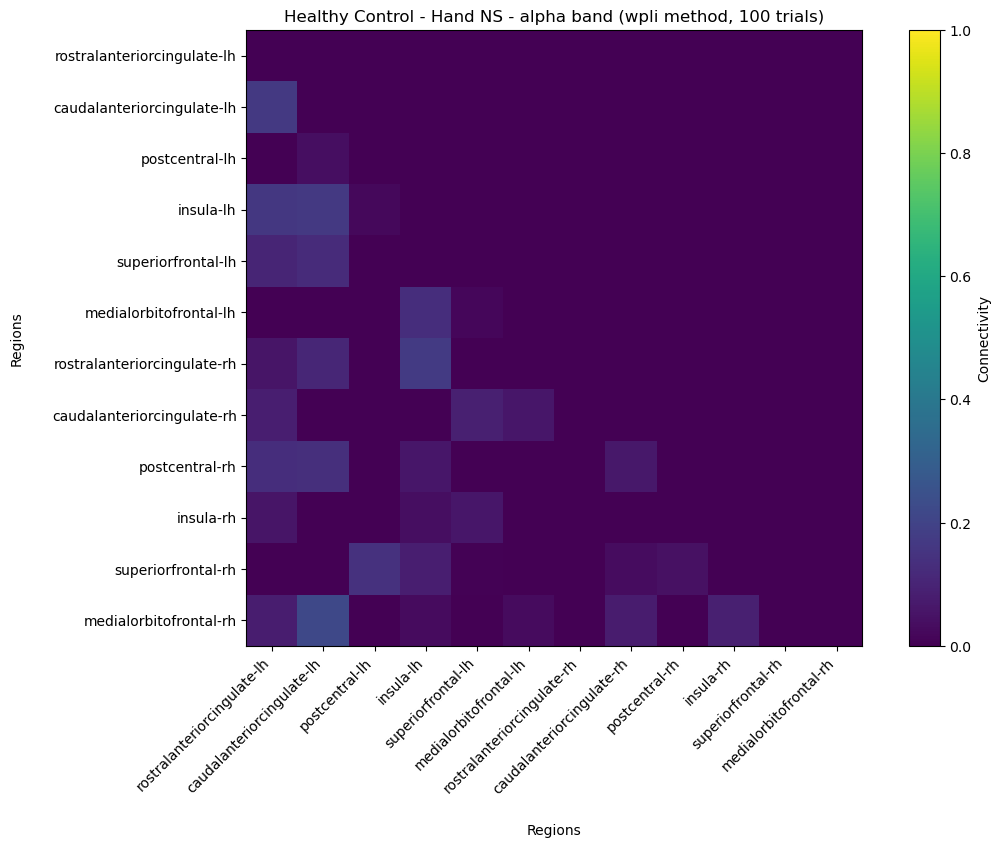

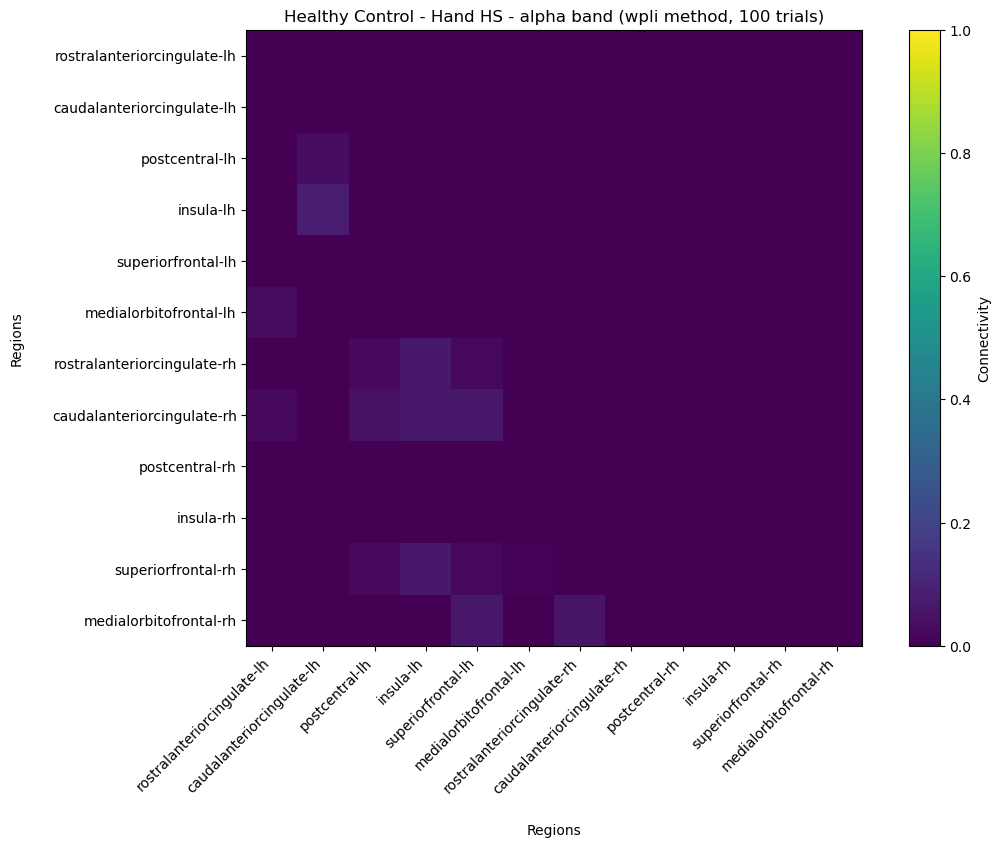

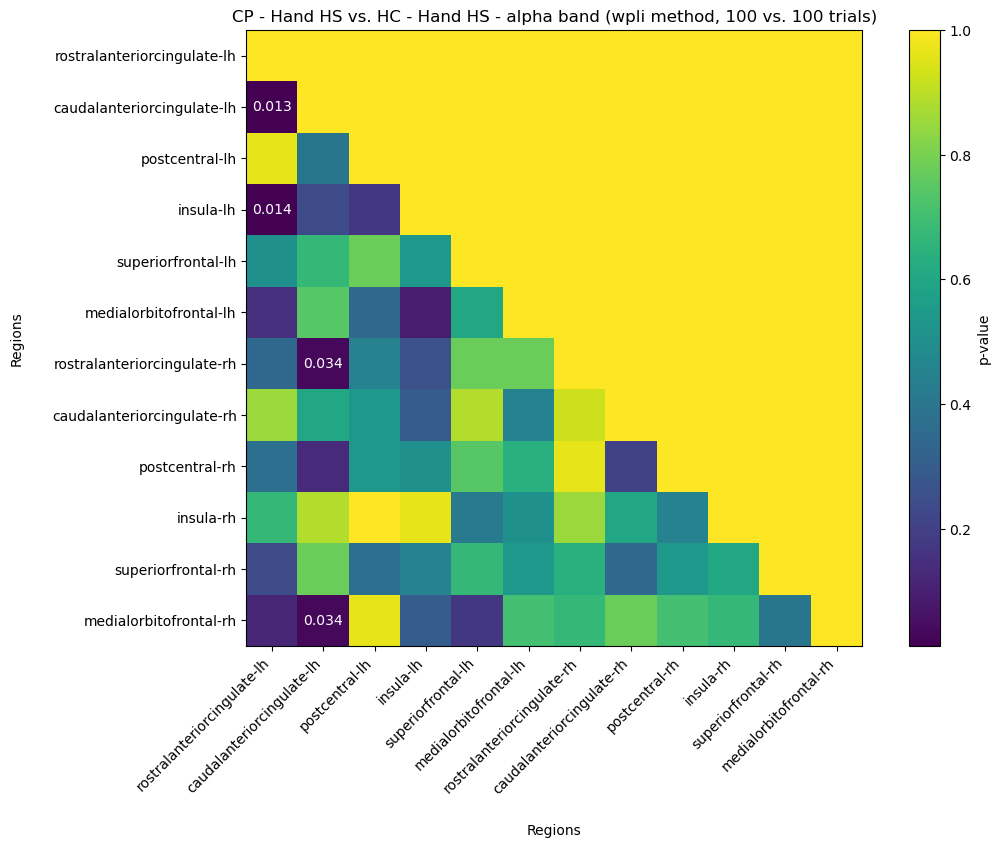

Hand HS - H vs. e - wpli2_debiased - low-gamma
Number of epochs in H Hand HS = 100
Number of epochs in e Hand HS = 100


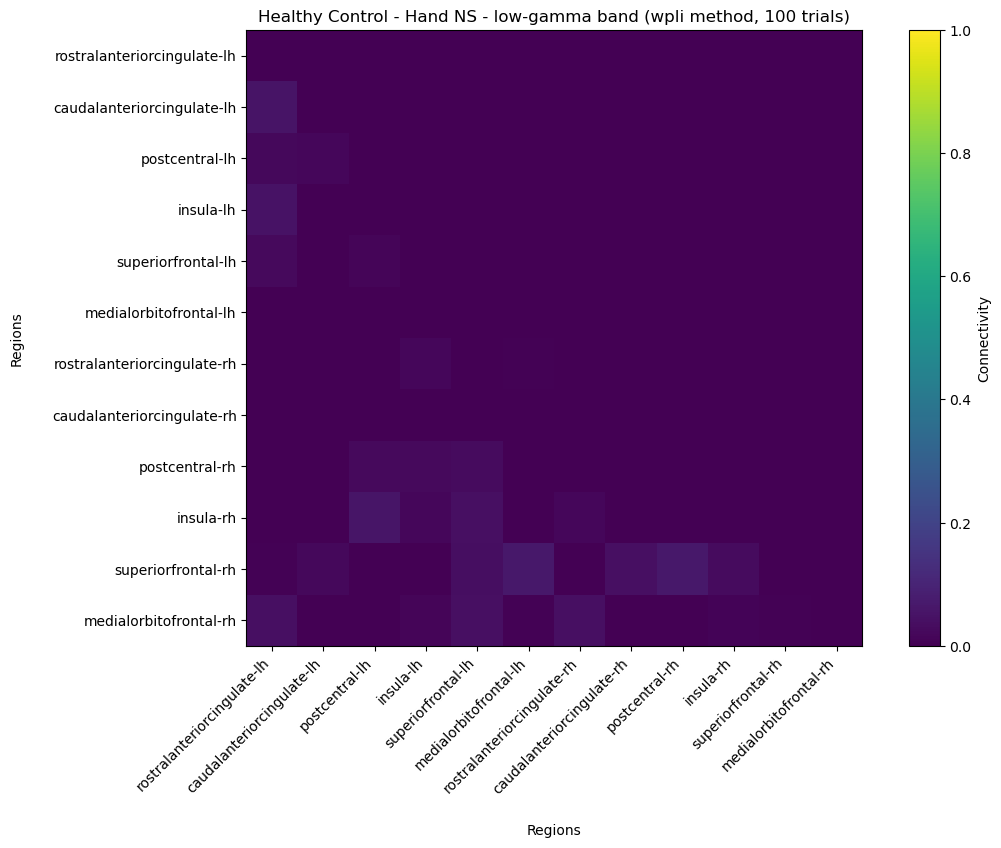

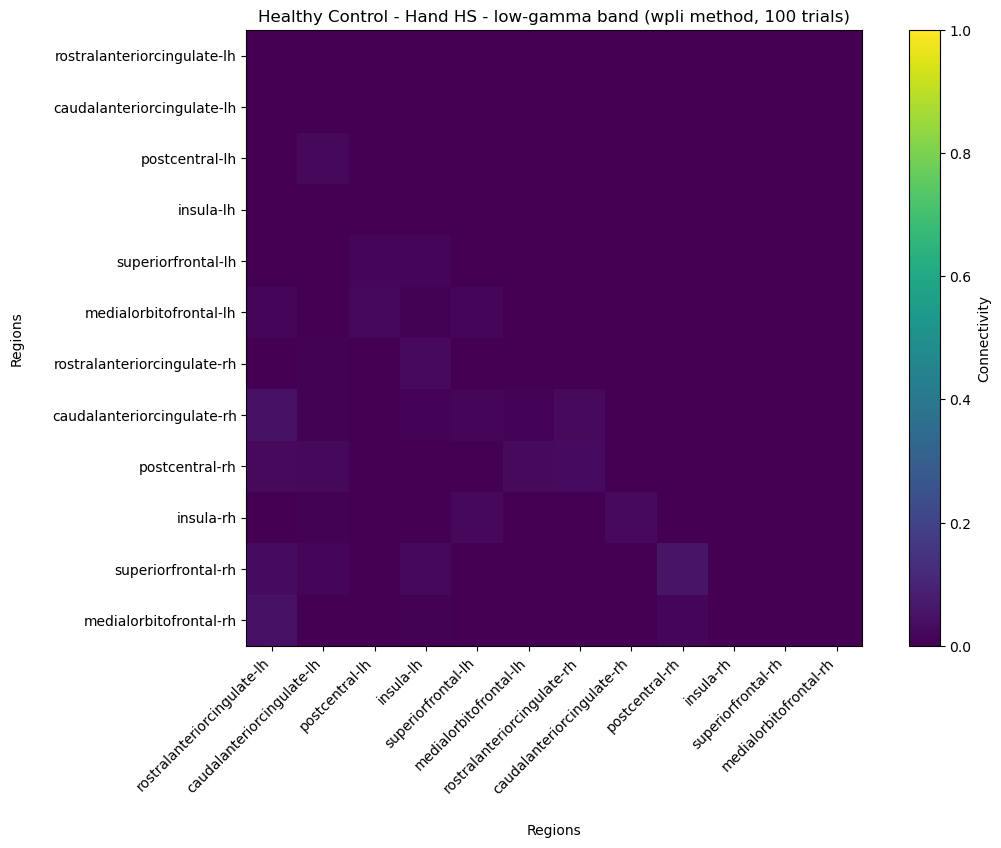

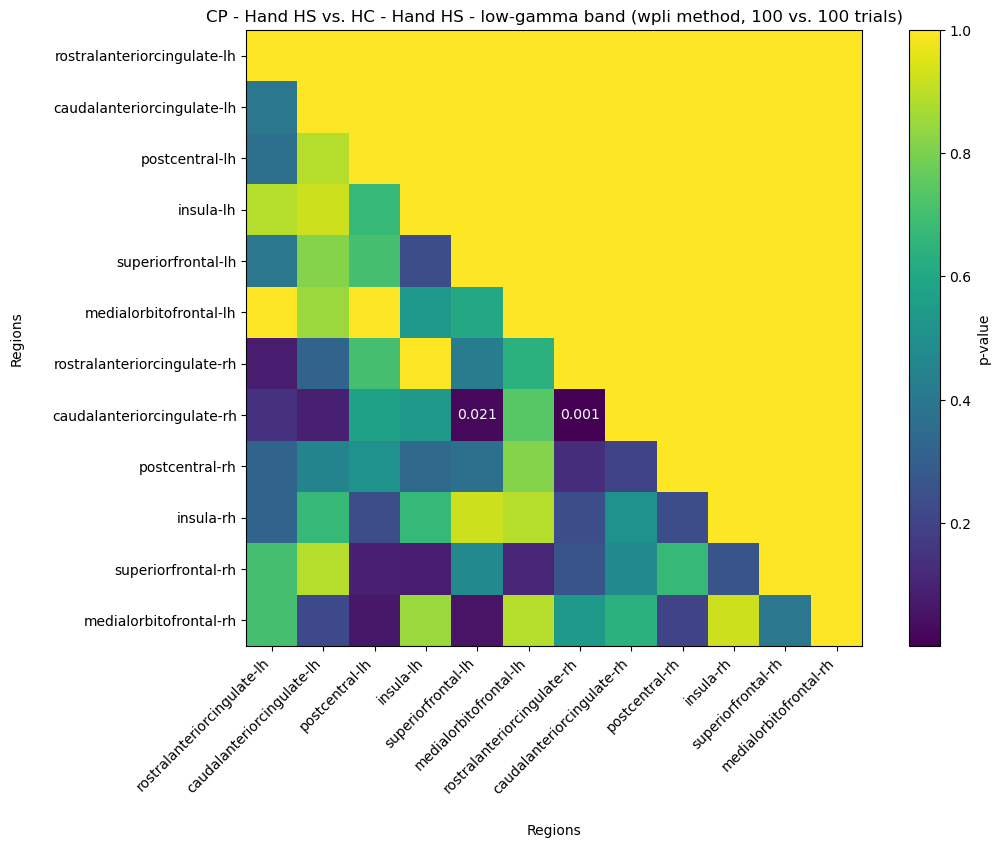

Hand HS - H vs. e - wpli2_debiased - high-gamma
Number of epochs in H Hand HS = 100
Number of epochs in e Hand HS = 100


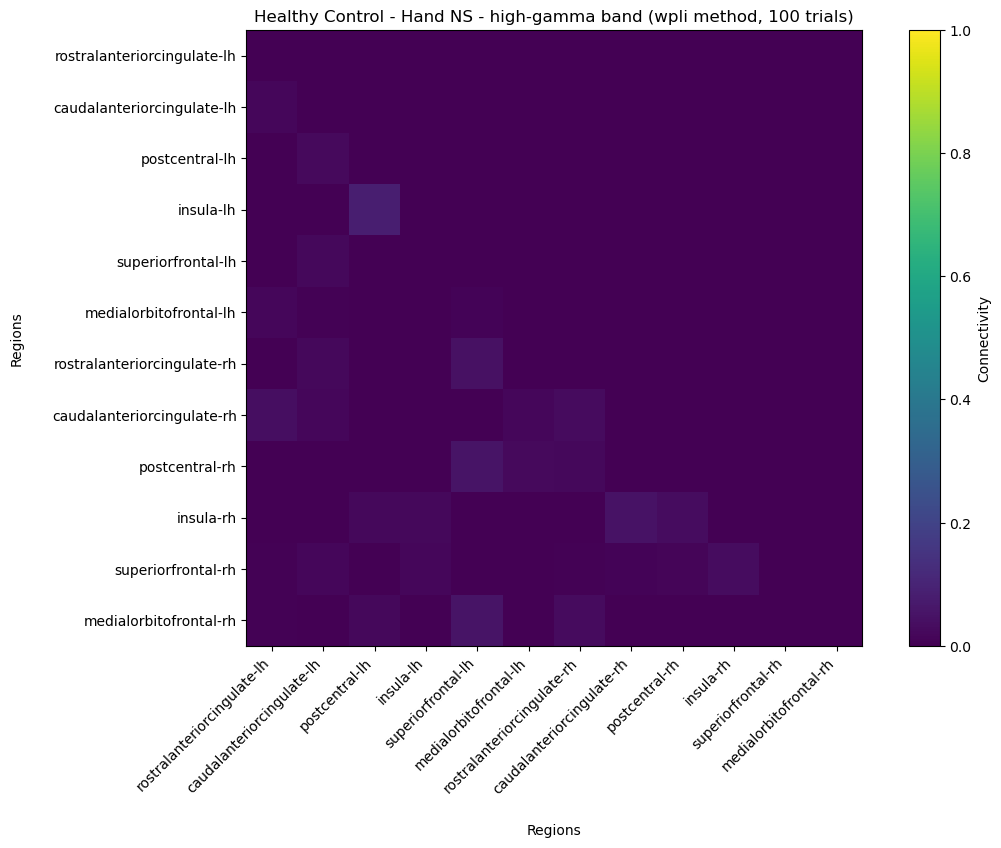

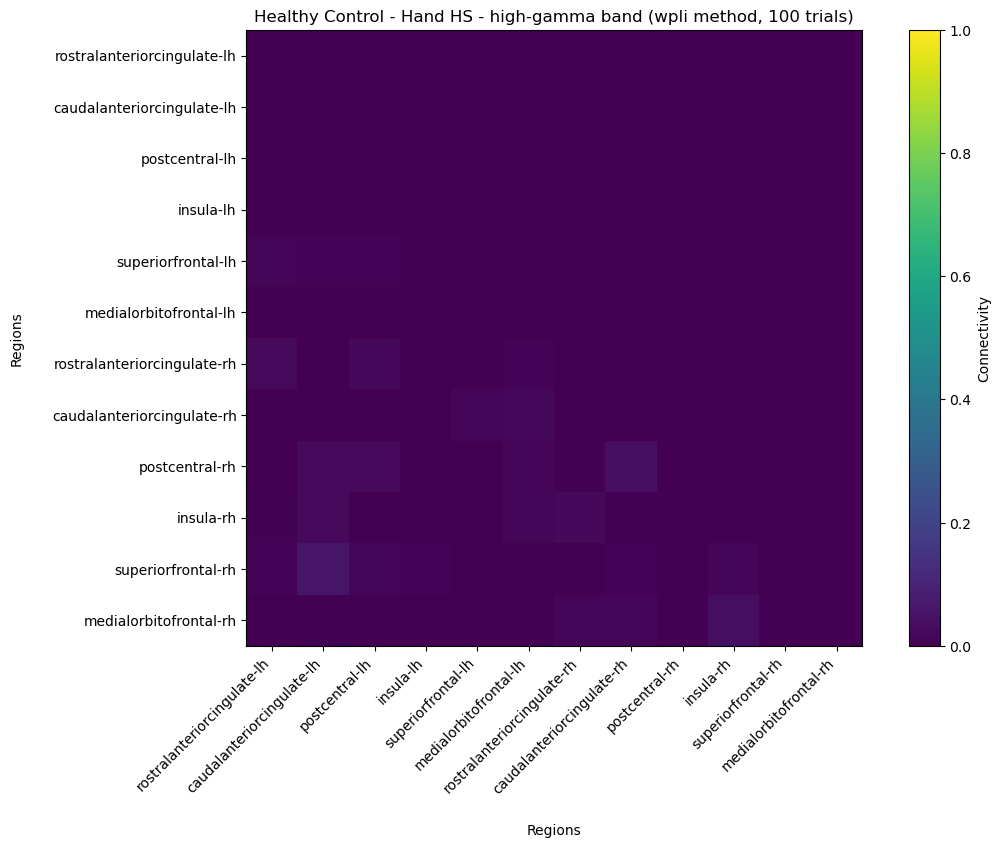

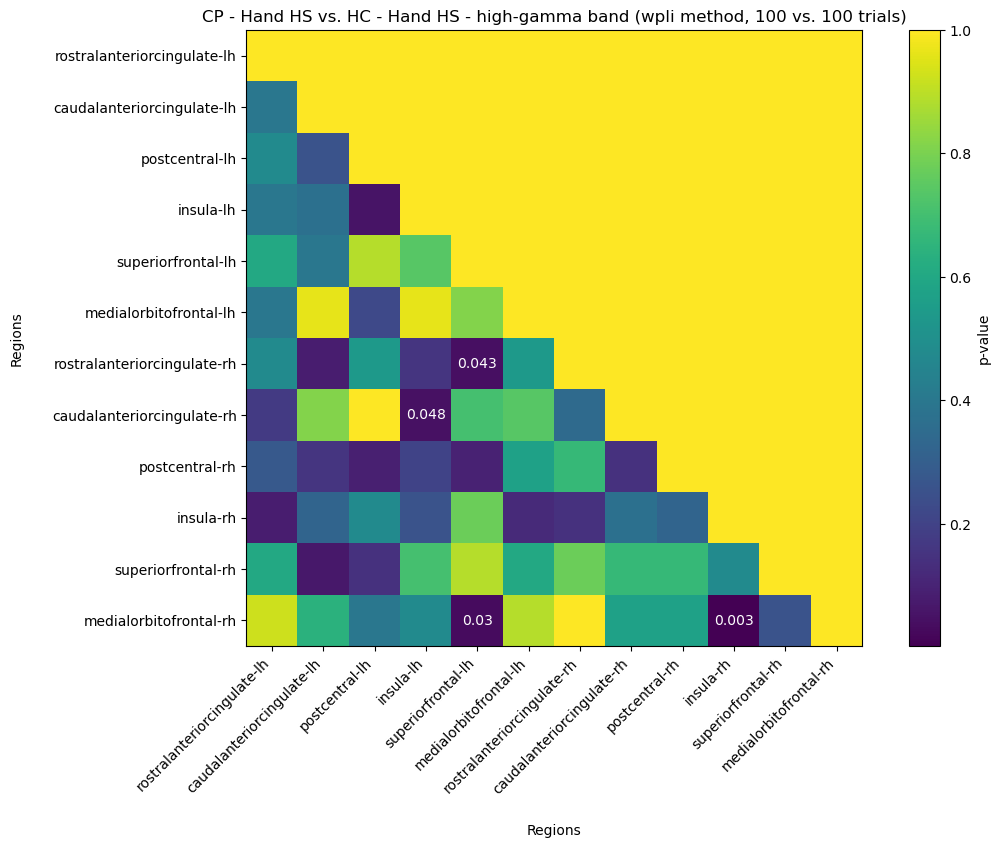

In [ ]:
# 3. CP Widespread Pain vs. CP without Widespread Pain
condition = "Hand HS"
stats_save_path = save_path / "CP_WSP_vs_CP_wo_WSP"
os.makedirs(stats_save_path, exist_ok=True)

for method in con_methods:
    for band in band_names:
        # Select groups for mann-whitney
        print(f"{condition} - {groups[0]} vs. {groups[1]} - {method} - {band}")
        group1_stack = group_con_CP[condition][method][band]
        group2_stack = group_con_HC[condition][method][band]

        nepochs_1 = group_con_CP[condition]['num_epochs']
        nepochs_2 = group_con_CP[condition]['num_epochs']
        print(f"Number of epochs in {groups[0]} {condition} = {nepochs_1}")
        print(f"Number of epochs in {groups[1]} {condition} = {nepochs_2}")
        
        # Compute the Mann-Whitney U test
        p_values, means_1, sem_1, means_2, sem_2 = fc.mann_whitney_test(
            group1_stack, group2_stack,roi_names)

        # Plotting            
        # Gather the information for plotting
        plot_kwargs= dict(
            method=method, band=band, 
            roi_names=roi_names,
            group_name=group_name)
        
        fc.plot_connectivity(means_1, 
                                **plot_kwargs, 
                                condition=cond1, 
                                num_epochs=nepochs_1, 
                                save_path=stats_save_path)
        
        fc.plot_connectivity(means_2, 
                                **plot_kwargs, 
                                condition=cond2, 
                                num_epochs=nepochs_2, 
                                save_path=stats_save_path)
        fc.plot_connectivity(p_values, 
                                **plot_kwargs, 
                                condition="p-values", 
                                num_epochs=f"{nepochs_1} vs. {nepochs_2}", 
                                save_path=stats_save_path,
                                title_prefix="CP - Hand HS vs. HC - Hand HS",
                                save_fig=True)
        
            # fc.plot_connectivity_circle(con_data, **plot_kwargs, save_path=save_path)